In [5]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
from tensorflow.keras import layers
from tqdm.auto import trange, tqdm

c:\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
(X_treino, y_treino), (X_teste, y_teste) = tf.keras.datasets.fashion_mnist.load_data()
X_treino = (X_treino / 127.5) - 1.0
X_treino = np.expand_dims(X_treino, axis=-1)

In [7]:
IMG_SIZE = 28
BATCH_SIZE = 128
timesteps = 16
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1)

In [8]:
def cvtImg(img):
    img = img - img.min()
    img = (img/img.max())
    return img.astype(np.float32)

In [9]:
def show_examples(x):
    num_images = x.shape[0]
    plt.figure(figsize=(10,10))
    for i in range(min(25, num_images)):
        plt.subplot(5, 5, i+1)
        img = cvtImg(x[i])
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis('off')

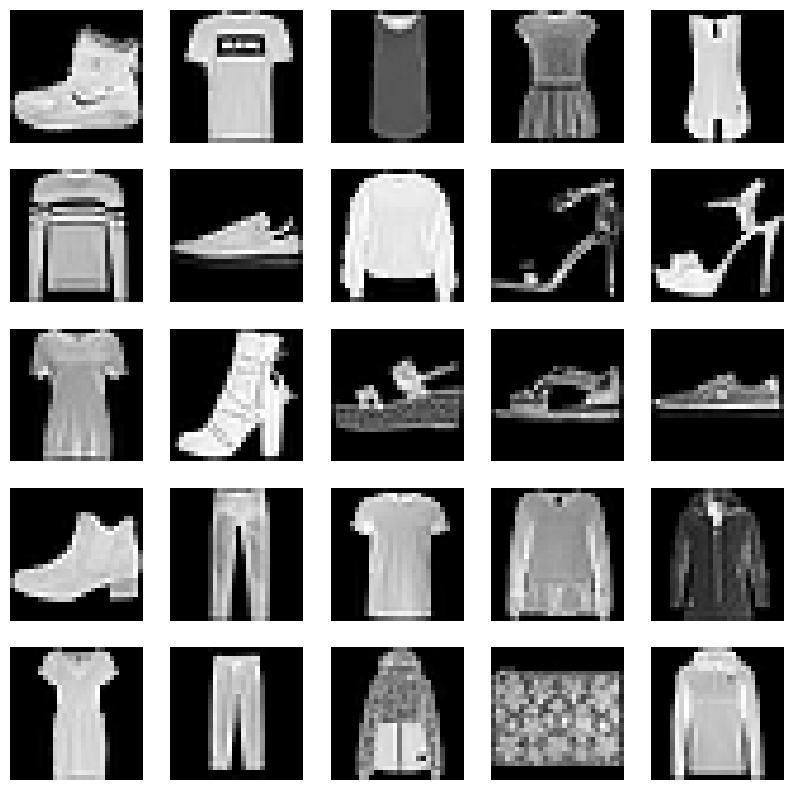

In [10]:
show_examples(X_treino)

In [17]:
def forward_noise(x, t):
    a = time_bar[t]
    b = time_bar[t+1]

    ruido = np.random.normal(size=x.shape)

    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))

    img_a = x * (1-a)+ruido*a
    img_b = x * (1-b)+ruido*b

    return img_a, img_b

In [18]:
def generate_ts(num):
    return np.random.randint(0,timesteps,size=num)


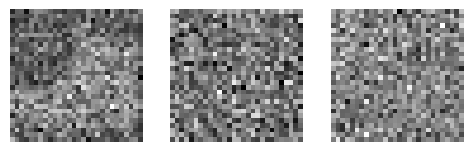

In [20]:
t = generate_ts(3)
a, b = forward_noise(X_treino[:3], t)
show_examples(a)

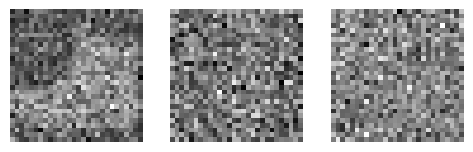

In [21]:
show_examples(b)

In [22]:
def block(x):
    x = layers.Conv2D(128, kernel_size=3, padding='same')(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

In [25]:
def make_model():
    x = x_input = layers.Input(shape=(28,28,1), name='x_input')
    x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
    x_ts = layers.Dense(192)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)

    x = x28 = block(x)
    x = layers.MaxPool2D(2, padding='same')(x)

    x = x14 = block(x)
    x = layers.MaxPool2D(2, padding='same')(x)

    x = x7 = block(x)
    x = layers.MaxPool2D(2, padding='same')(x)

    x = x4 = block(x)

    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(4 * 4 * 32)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((4, 4, 32))(x)

    x = layers.Concatenate()([x, x4])
    x = block(x)
    x = layers.Conv2DTranspose(128, kernel_size = 3, strides = 2, padding='same')(x)

    x = layers.Cropping2D(((0, 1), (0, 1)))(x)

    x = layers.Concatenate()([x, x7])
    x = block(x)
    x = layers.Conv2DTranspose(128, kernel_size = 3, strides = 2, padding='same')(x)

    x = layers.Concatenate()([x, x14])
    x = block(x)
    x = layers.Conv2DTranspose(128, kernel_size = 3, strides = 2, padding='same')(x)

    x = layers.Concatenate()([x, x28])
    x = block(x)

    x = layers.Conv2D(1, kernel_size = 1, padding='same')(x)
    model = tf.keras.models.Model([x_input, x_ts_input], x)
    return model

In [26]:
model = make_model()

In [31]:
model.compile(loss=tf.keras.losses.MeanAbsoluteError(),optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008))

In [32]:
def predict(model, timesteps=50, batch_size=32):
    x = np.random.normal(size=(batch_size, 28, 28,1))
    for i in trange(timesteps):
        t = np.full((batch_size, 1),i)
        x = model.predict([x,t], verbose=0)

        x = (x-x.min())/(x.max()-x.min())

        show_examples(x)


 40%|████      | 20/50 [00:08<00:12,  2.50it/s]C:\Users\nakaj\AppData\Local\Temp\ipykernel_14464\3853096967.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,10))
100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


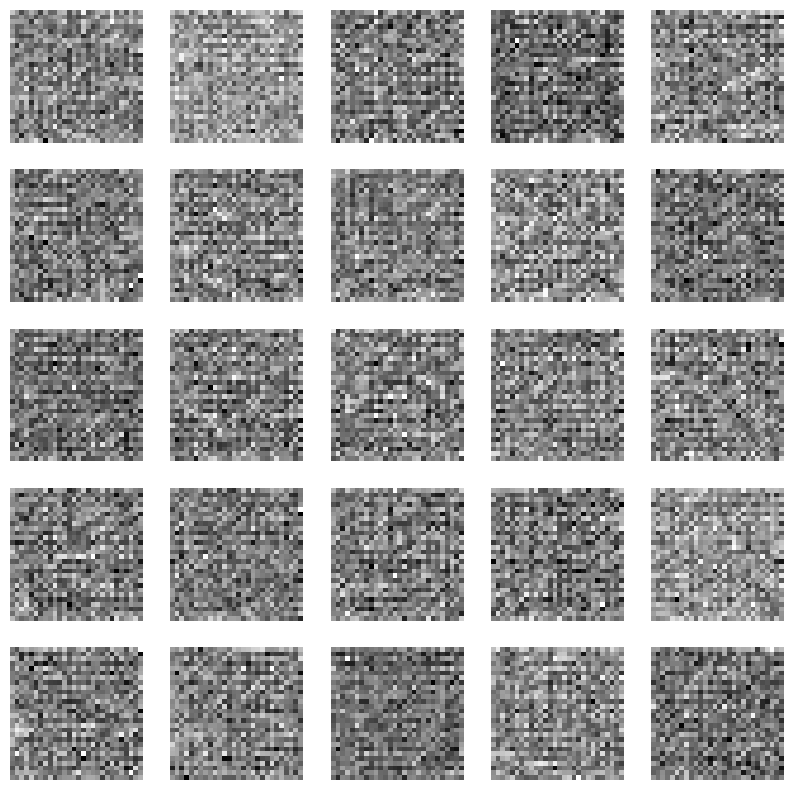

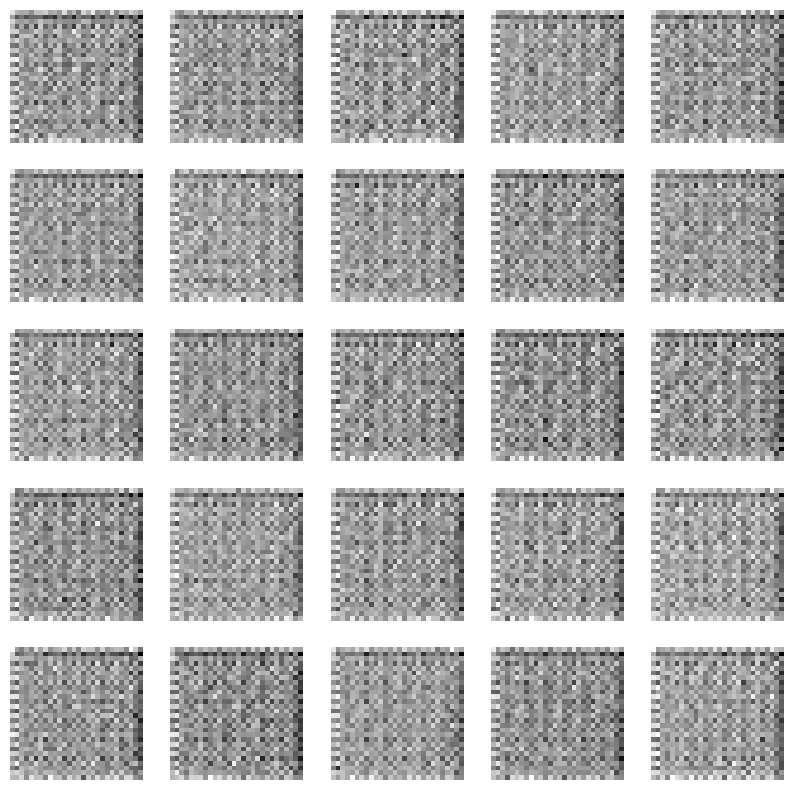

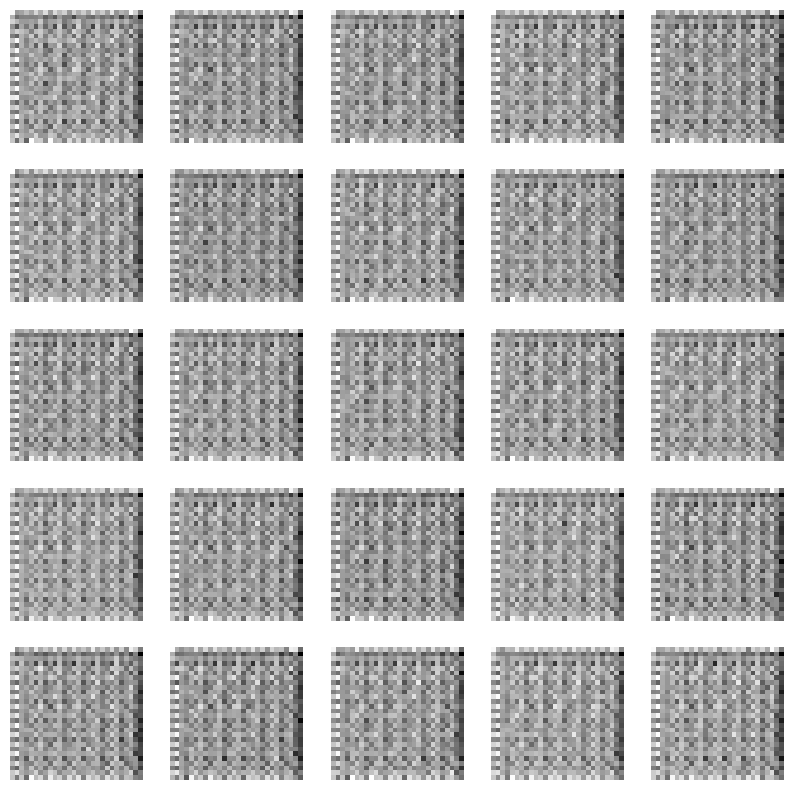

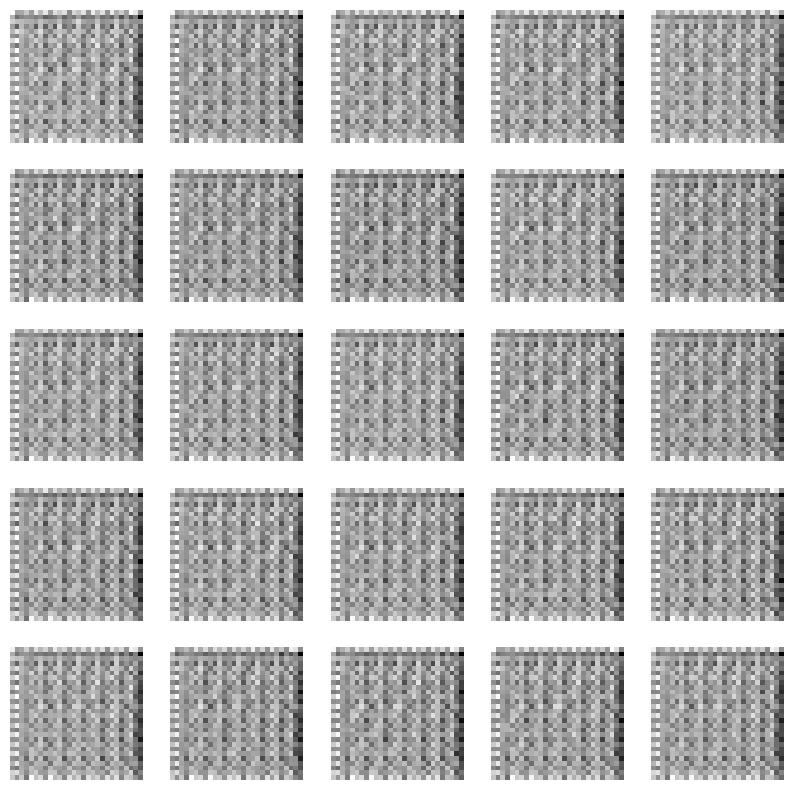

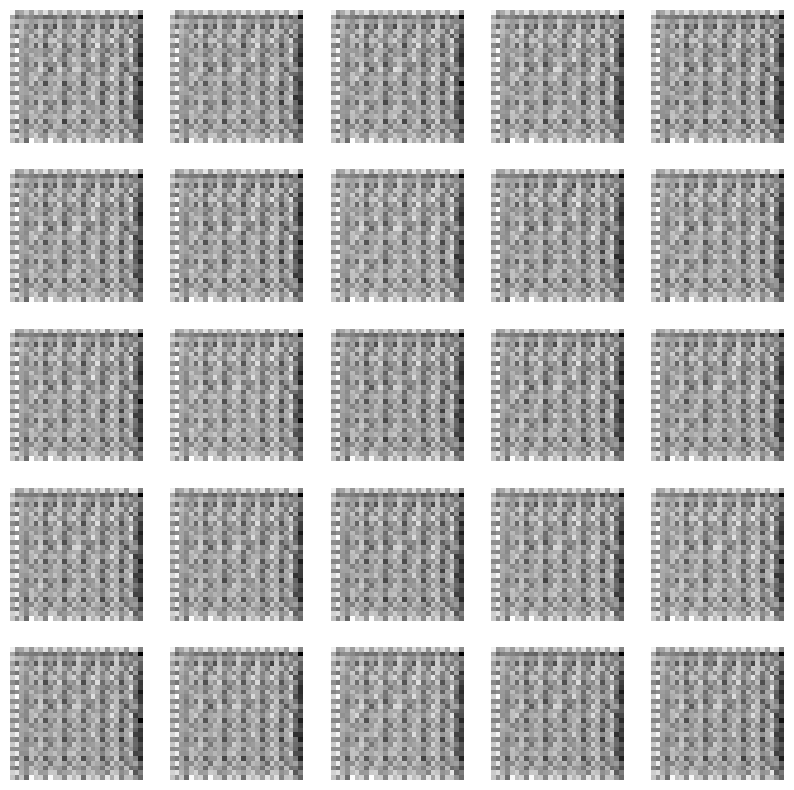

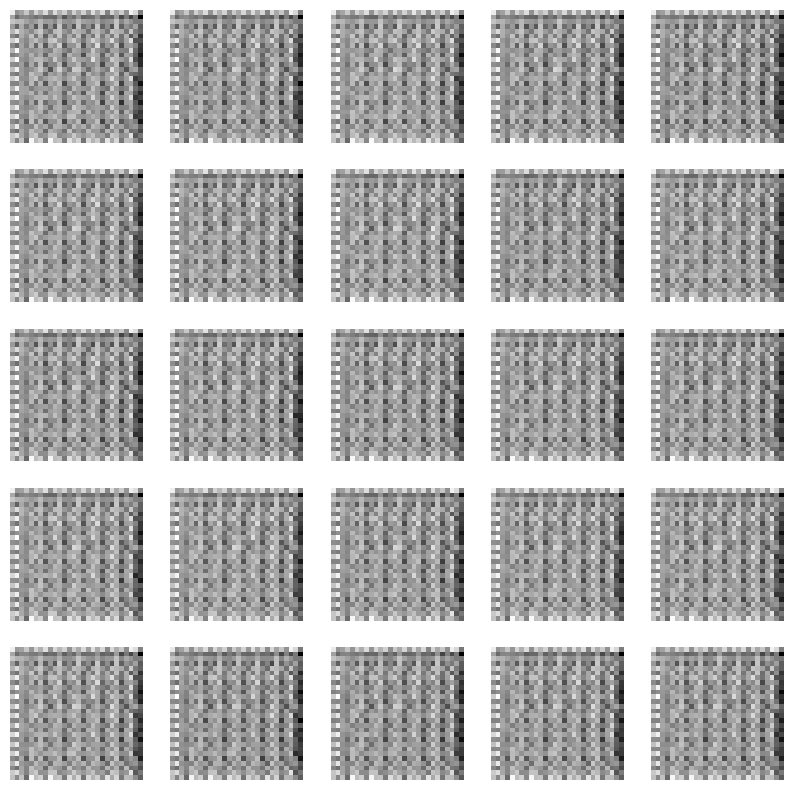

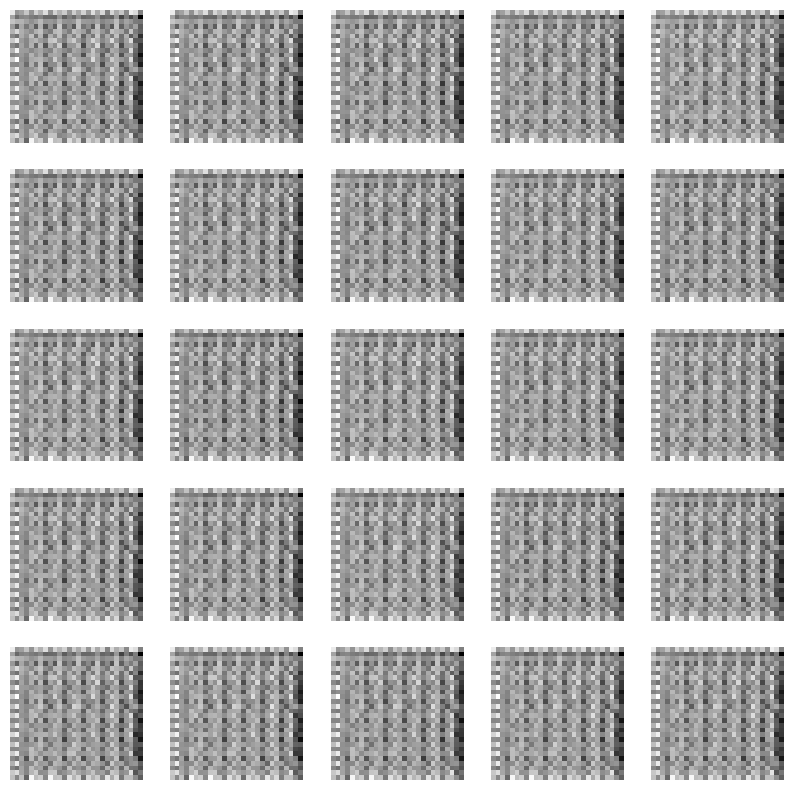

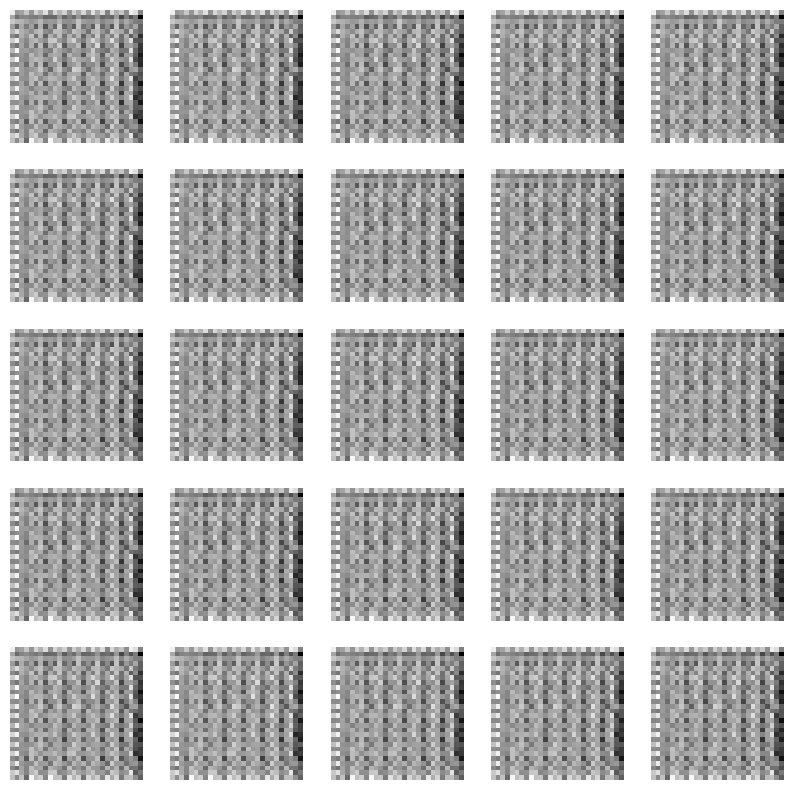

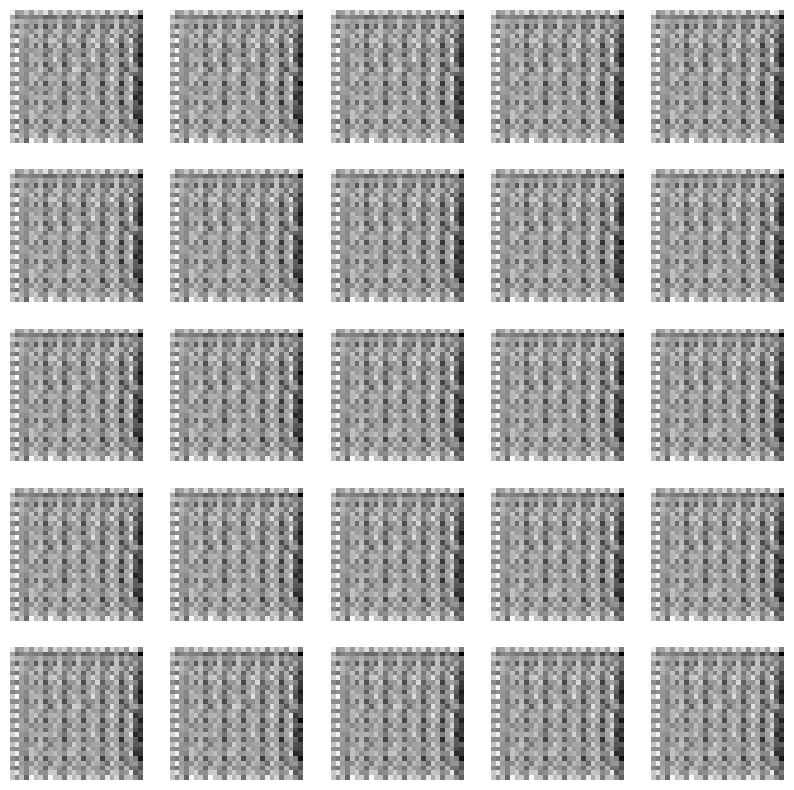

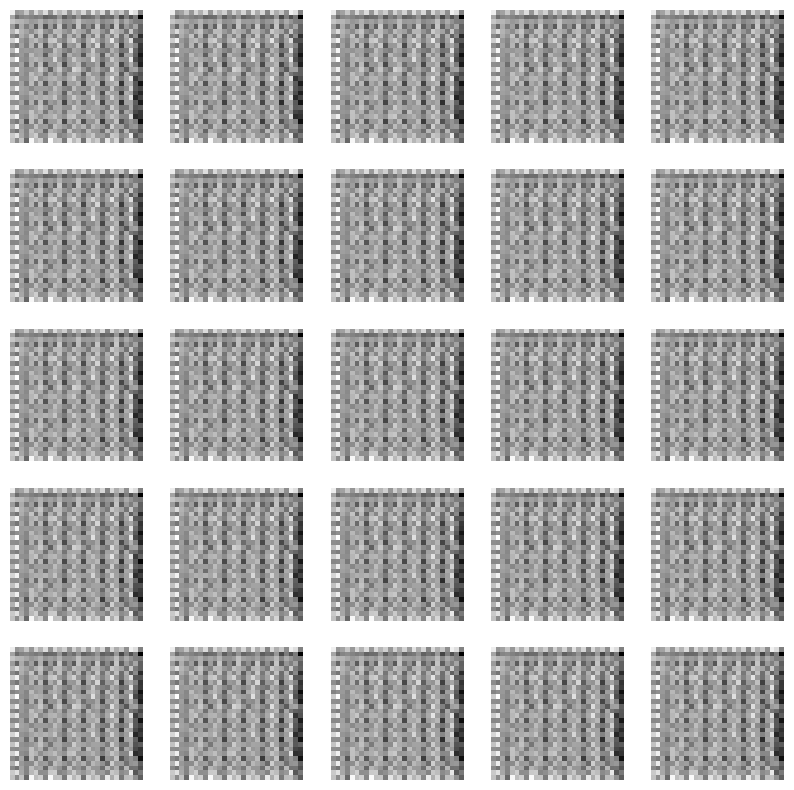

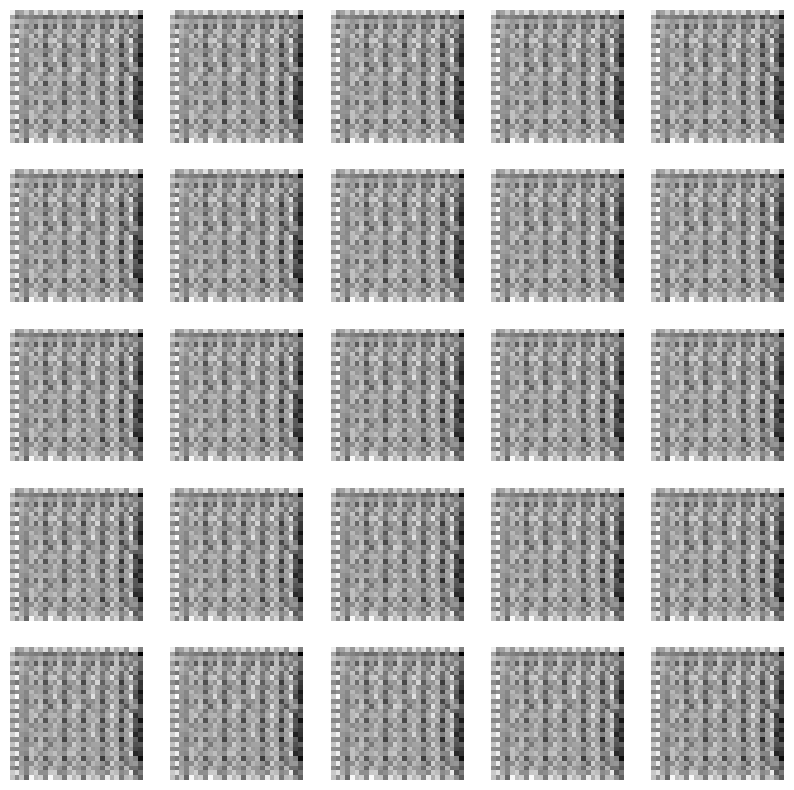

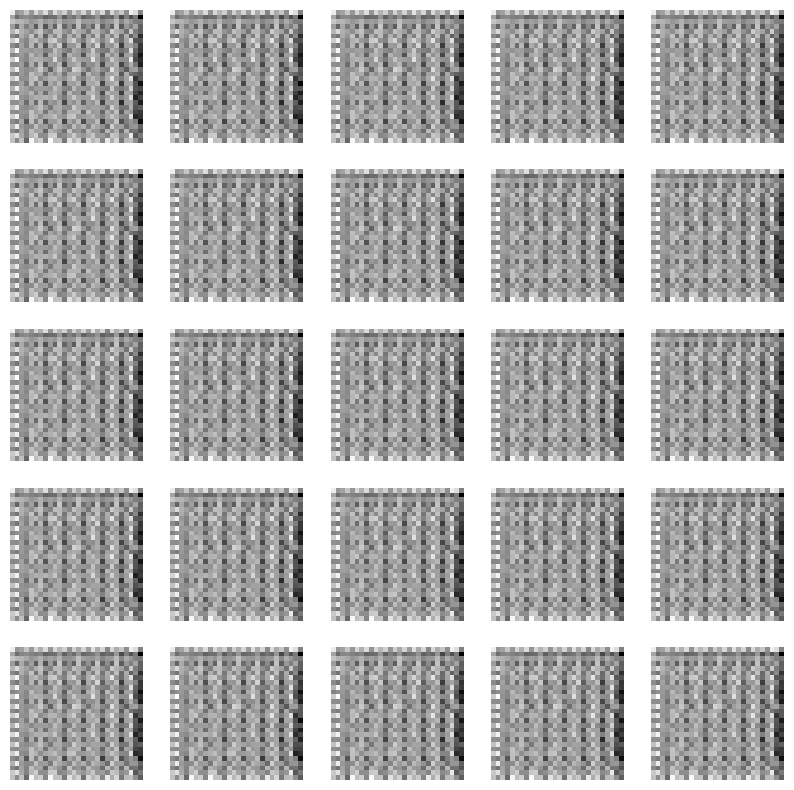

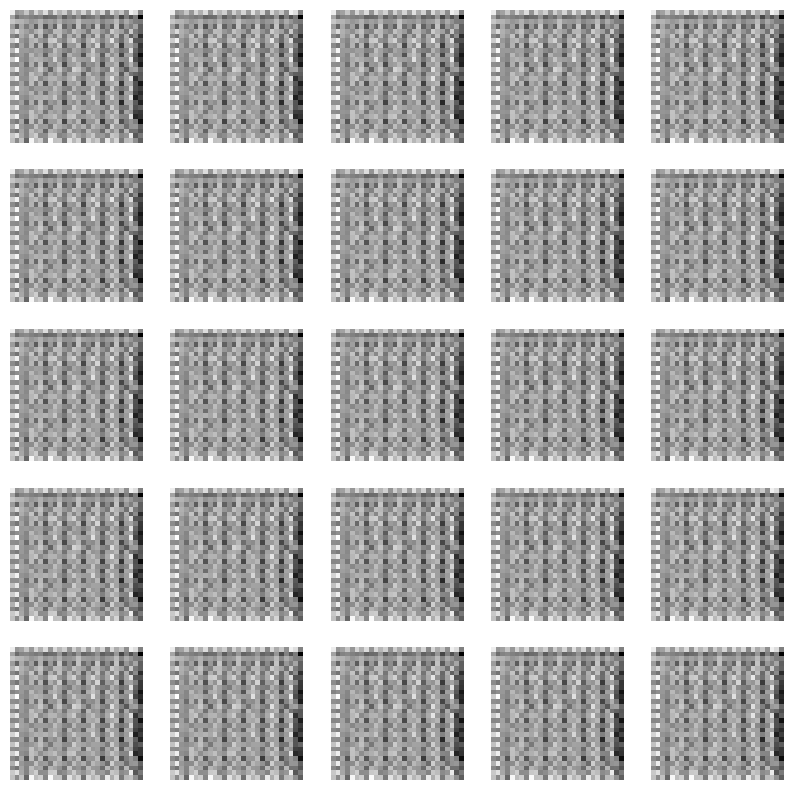

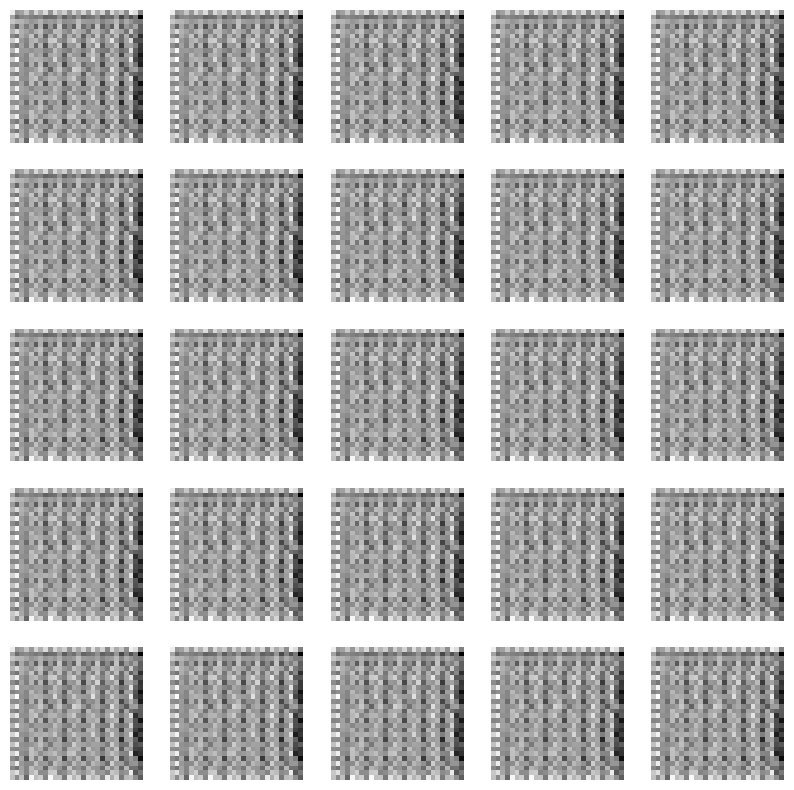

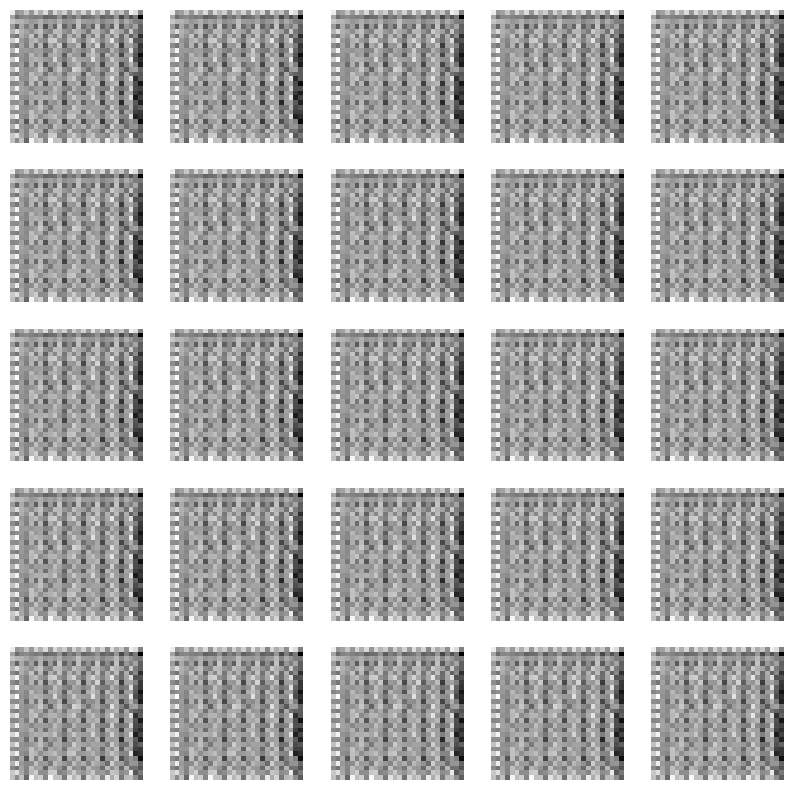

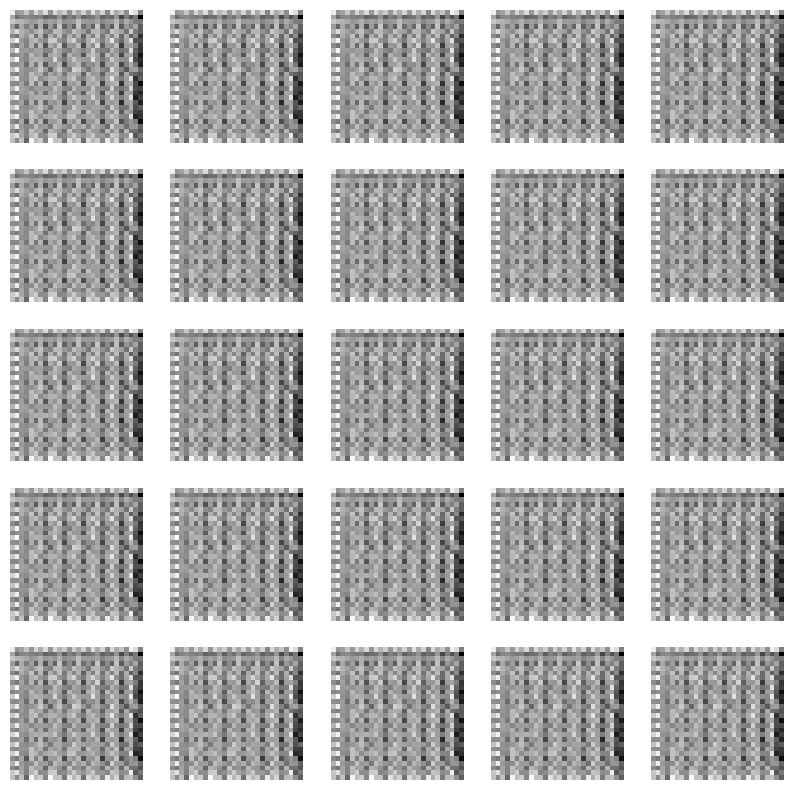

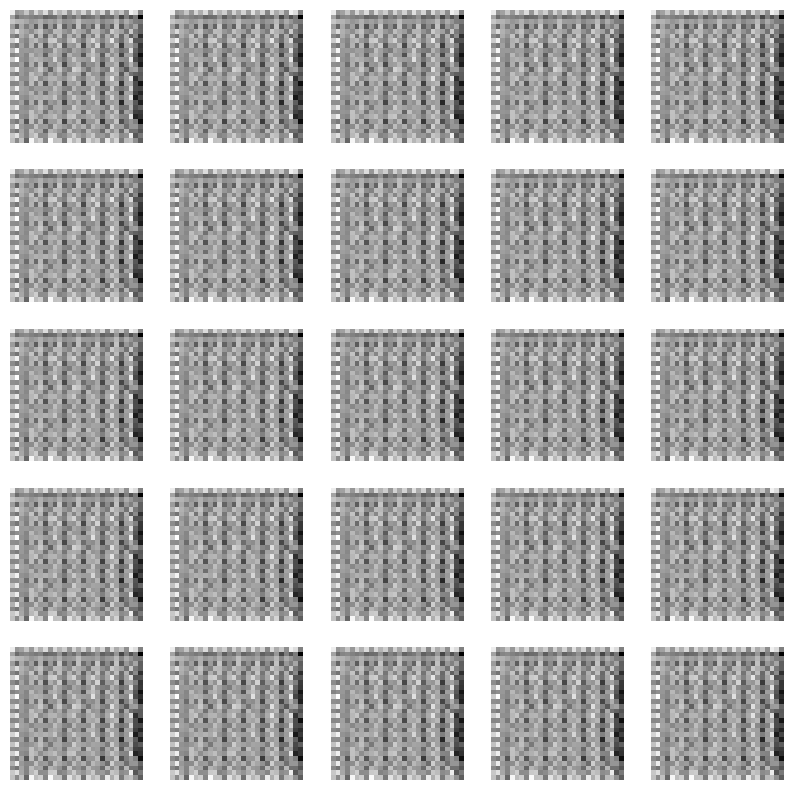

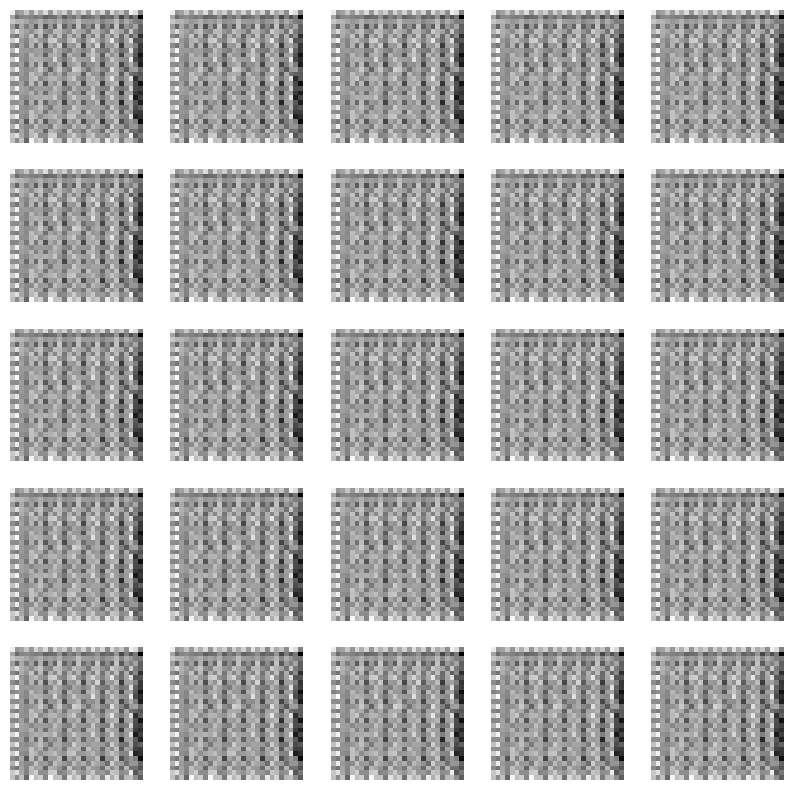

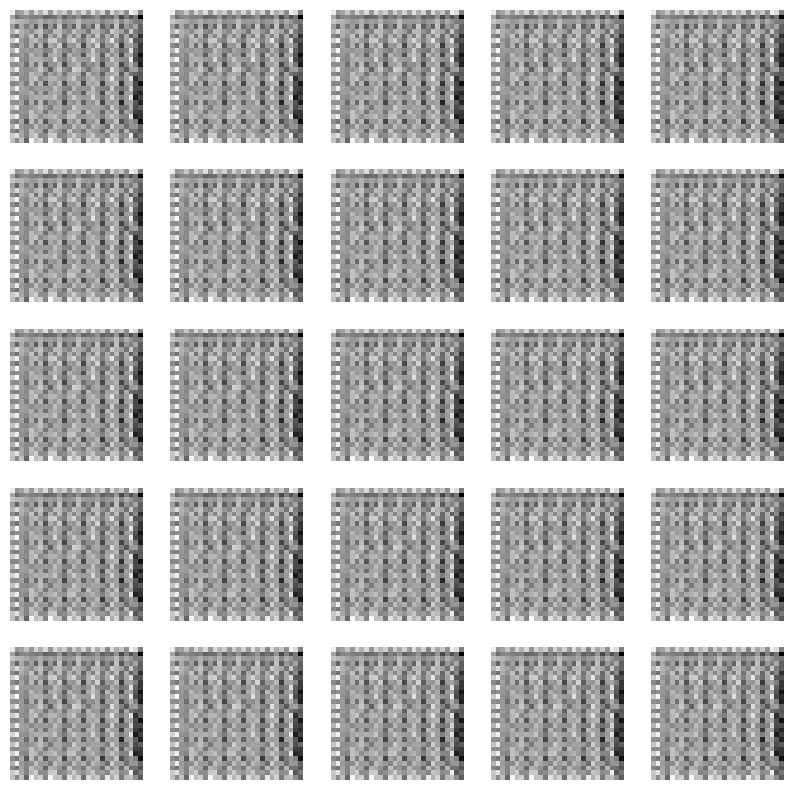

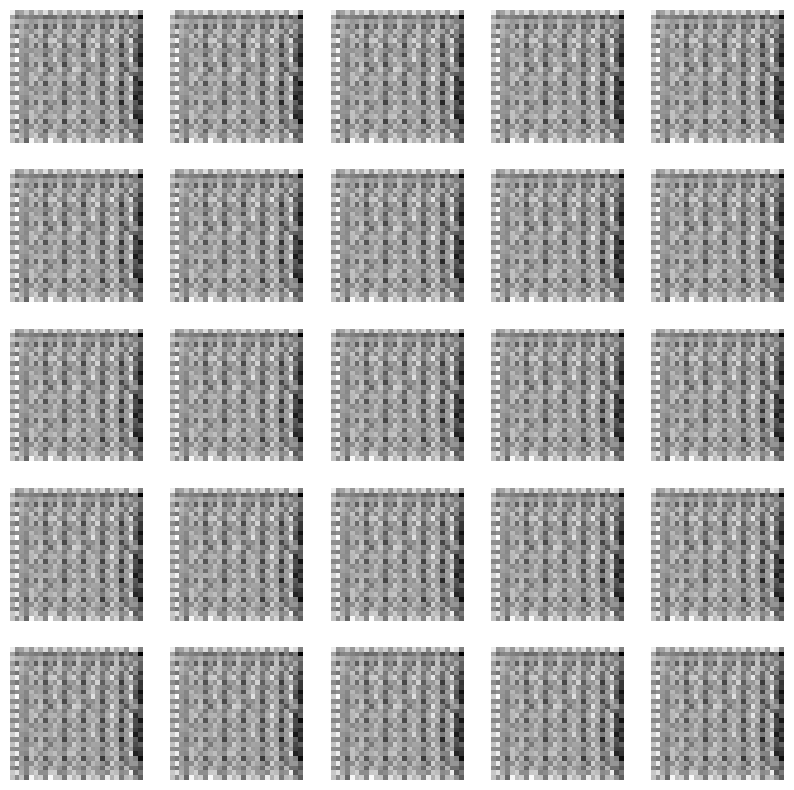

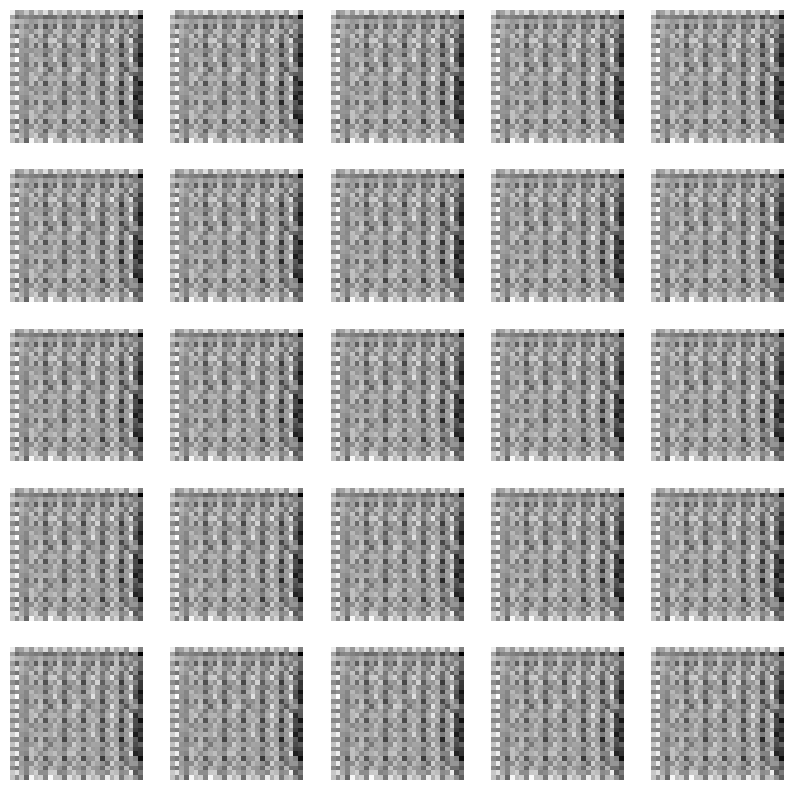

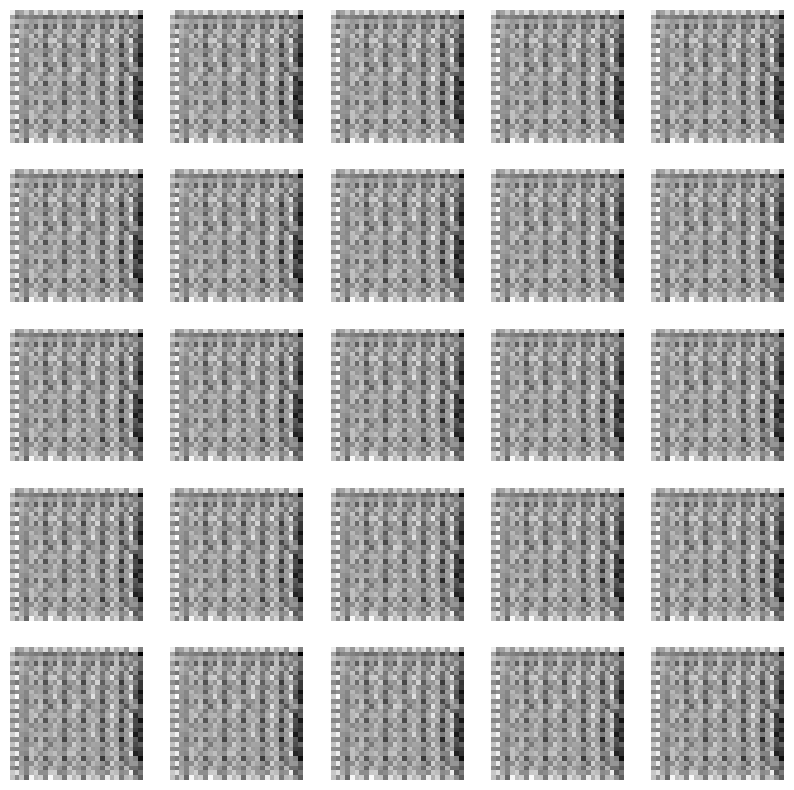

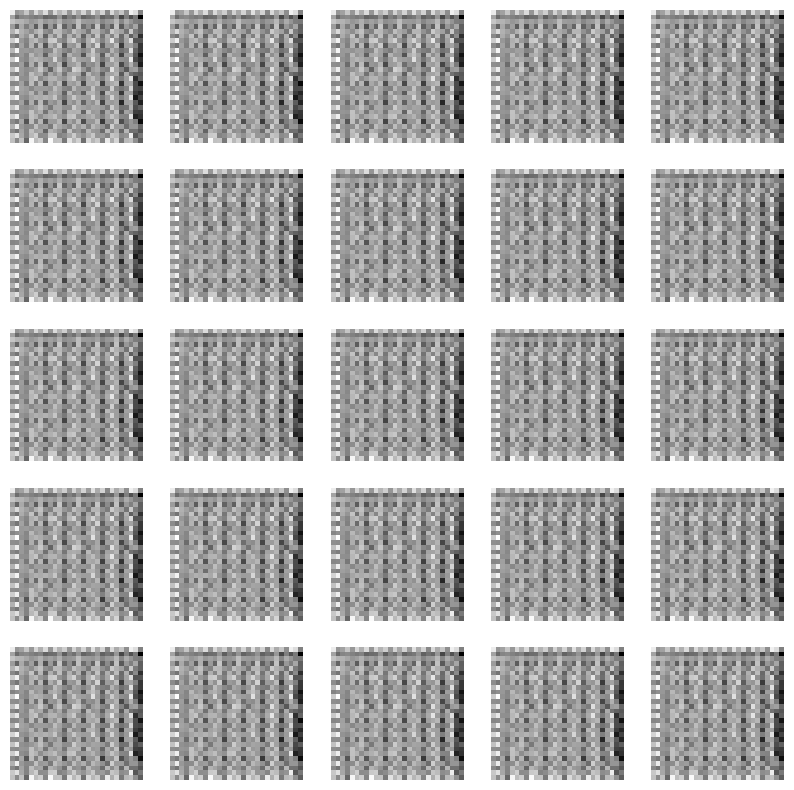

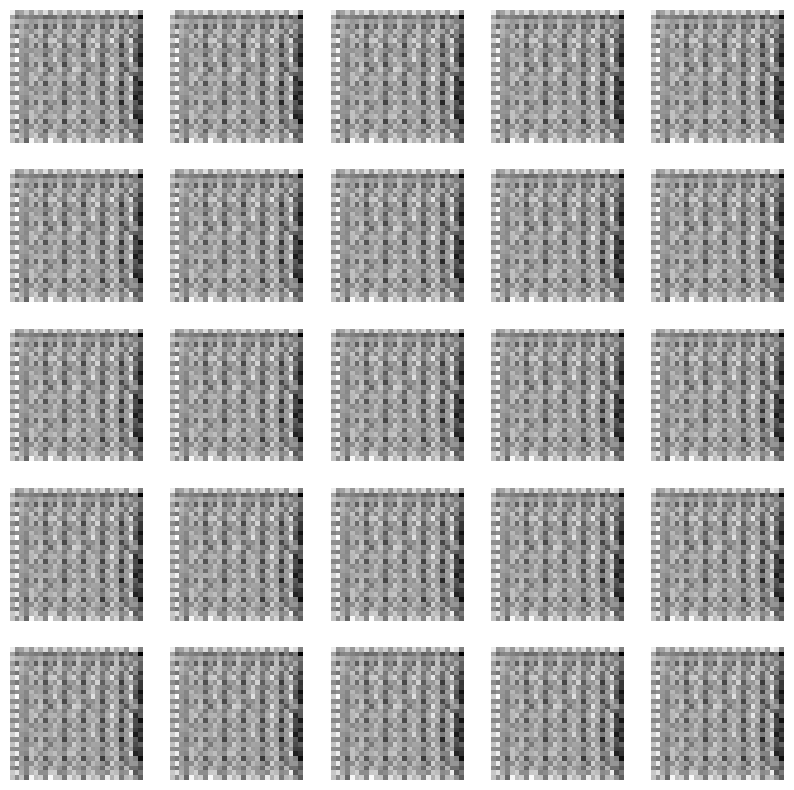

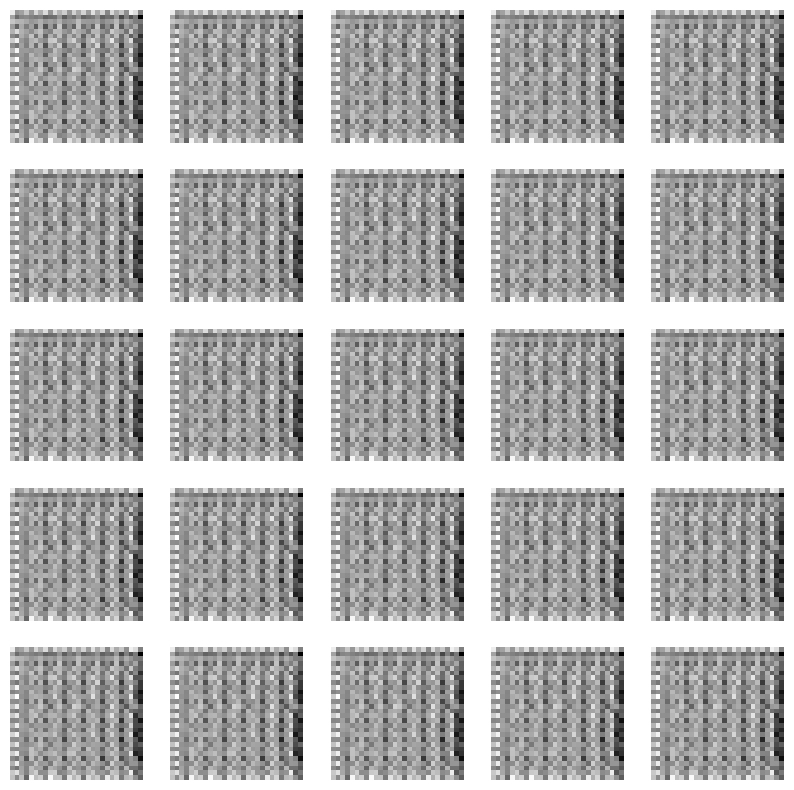

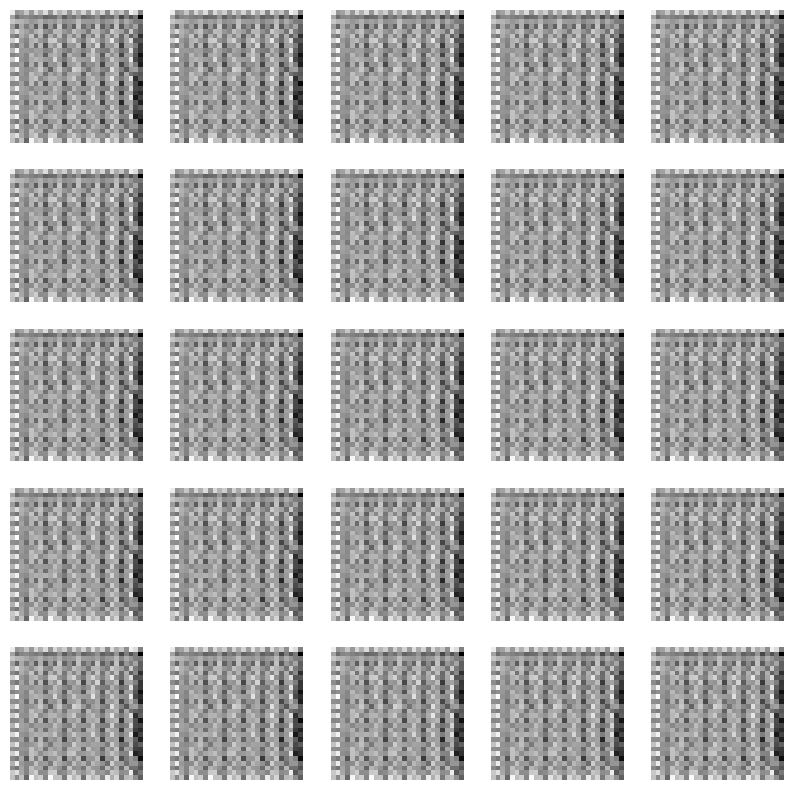

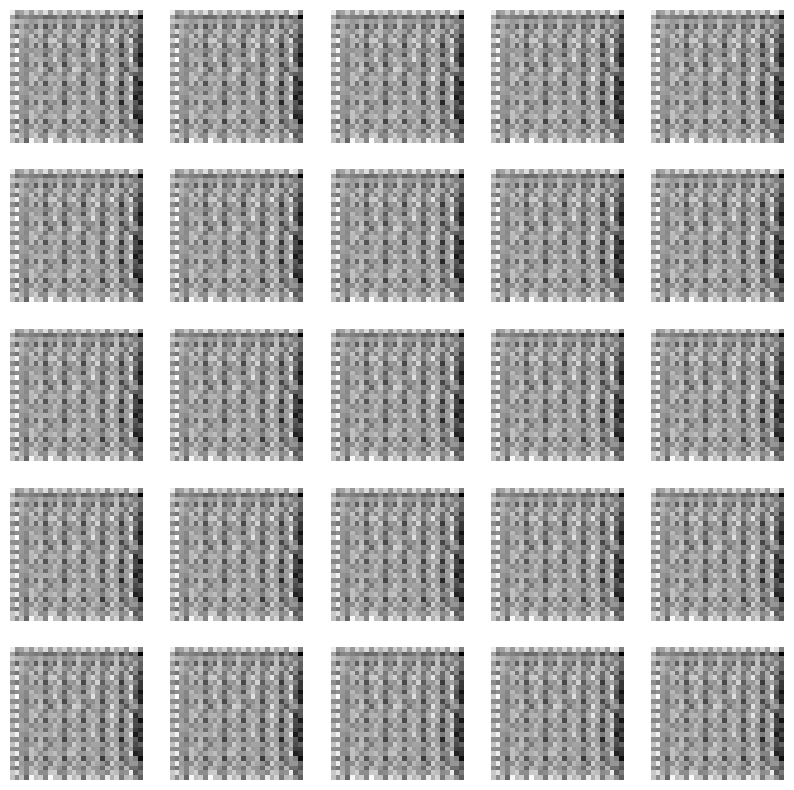

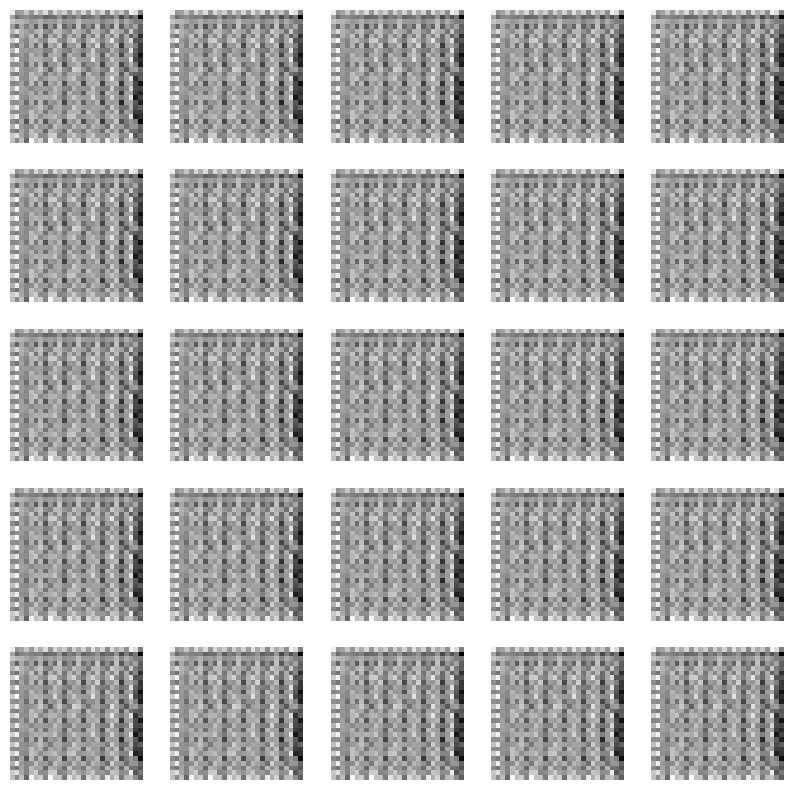

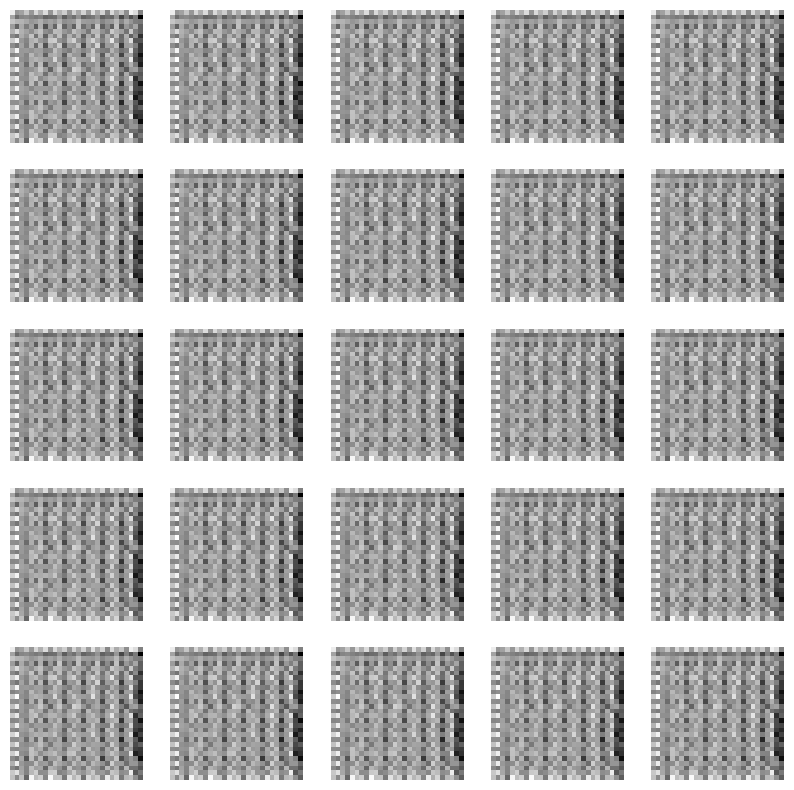

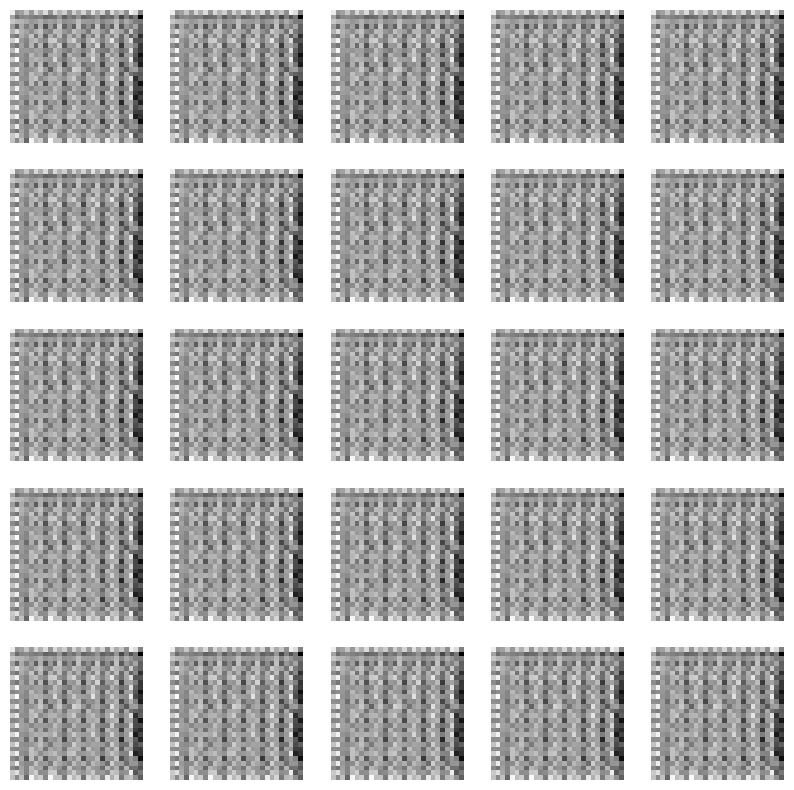

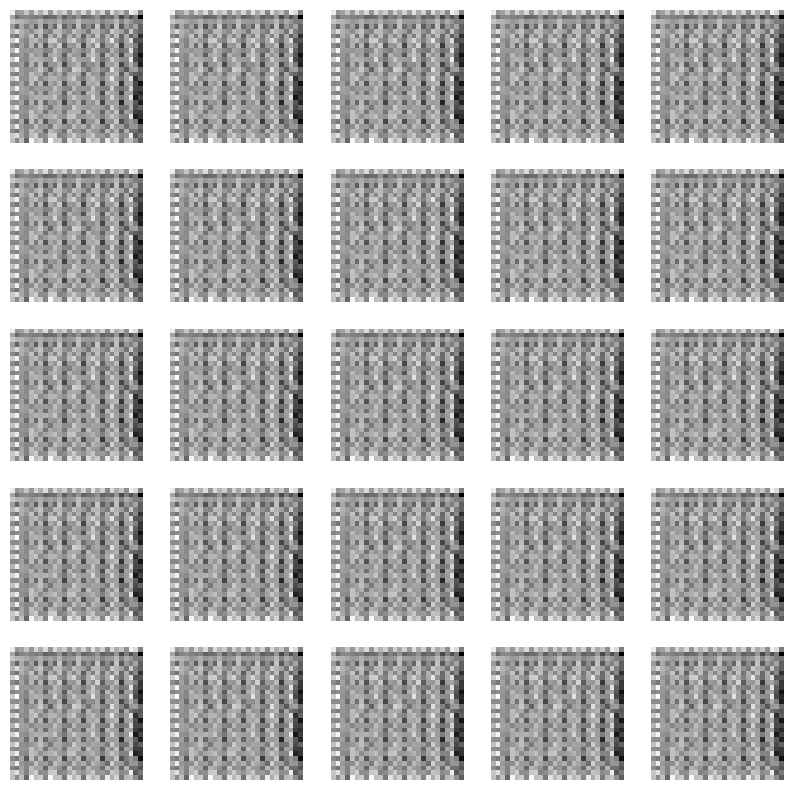

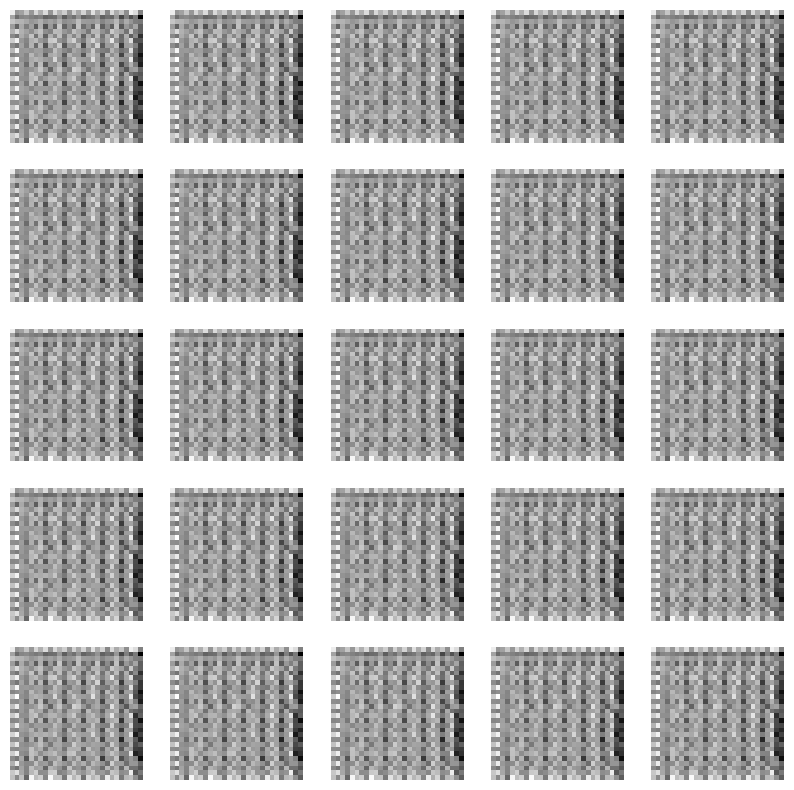

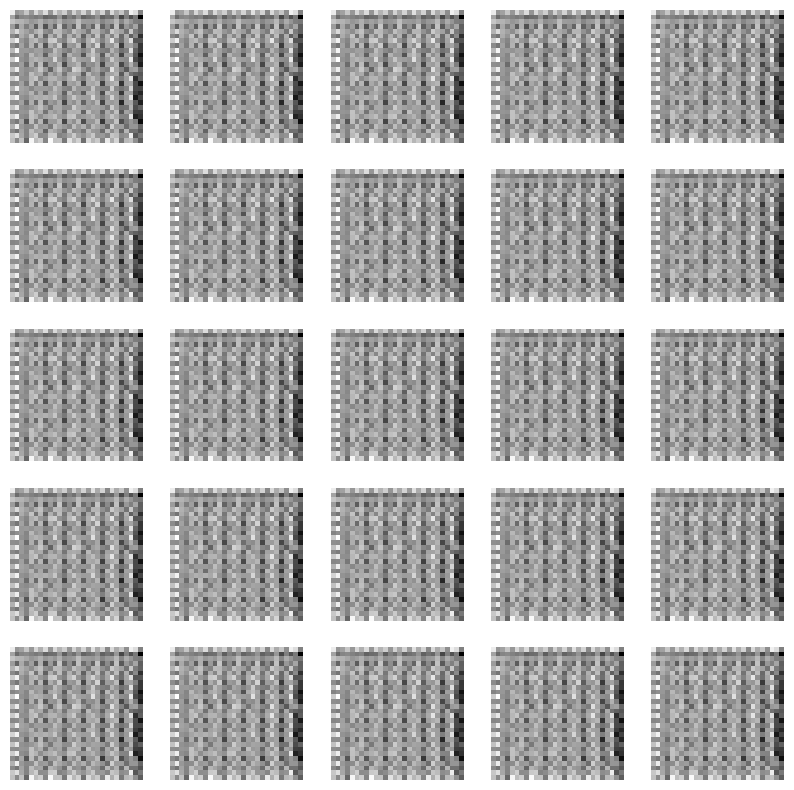

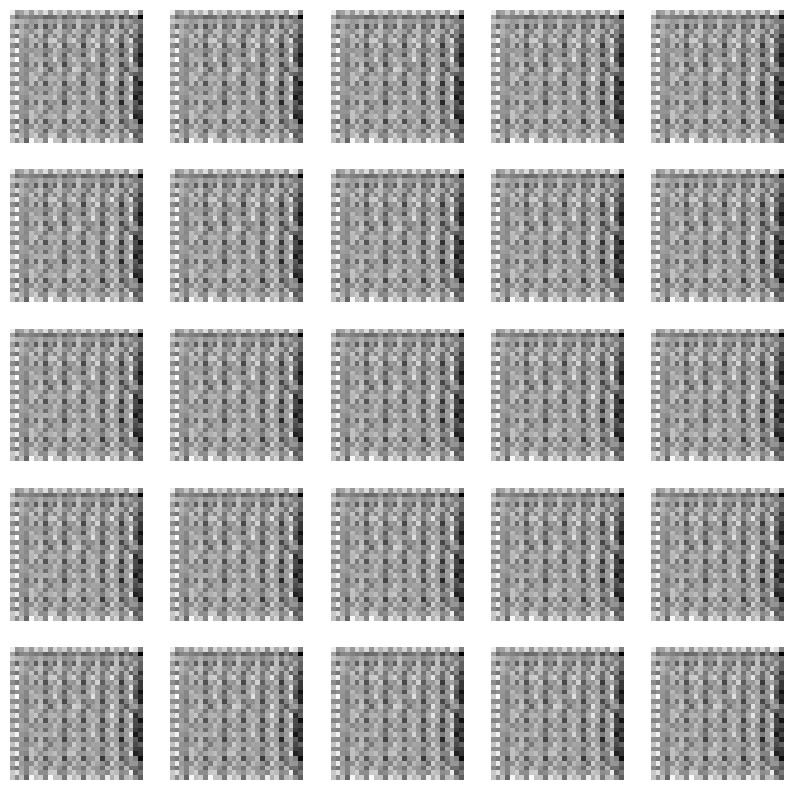

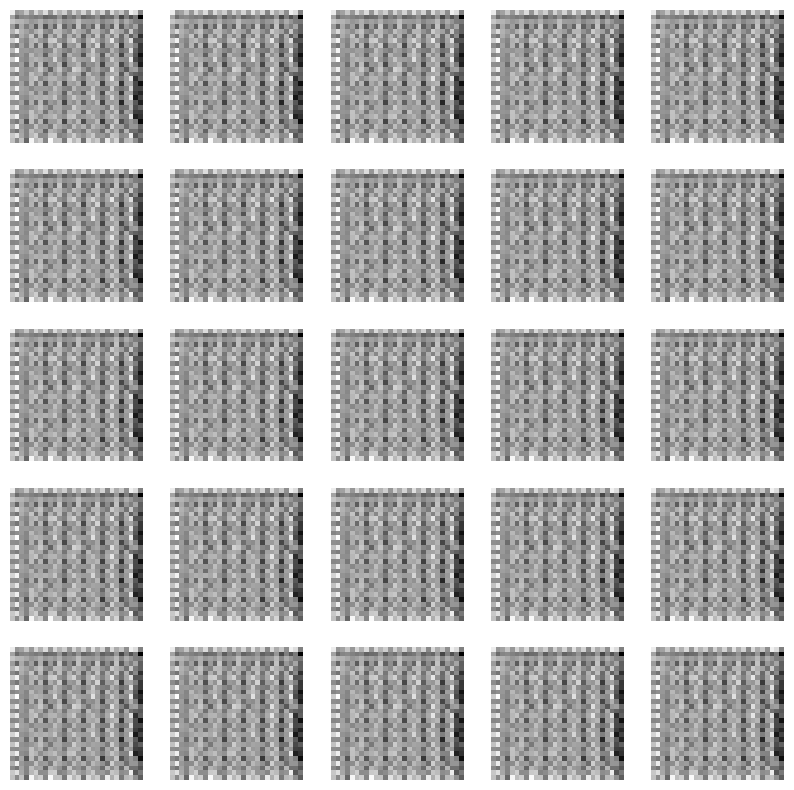

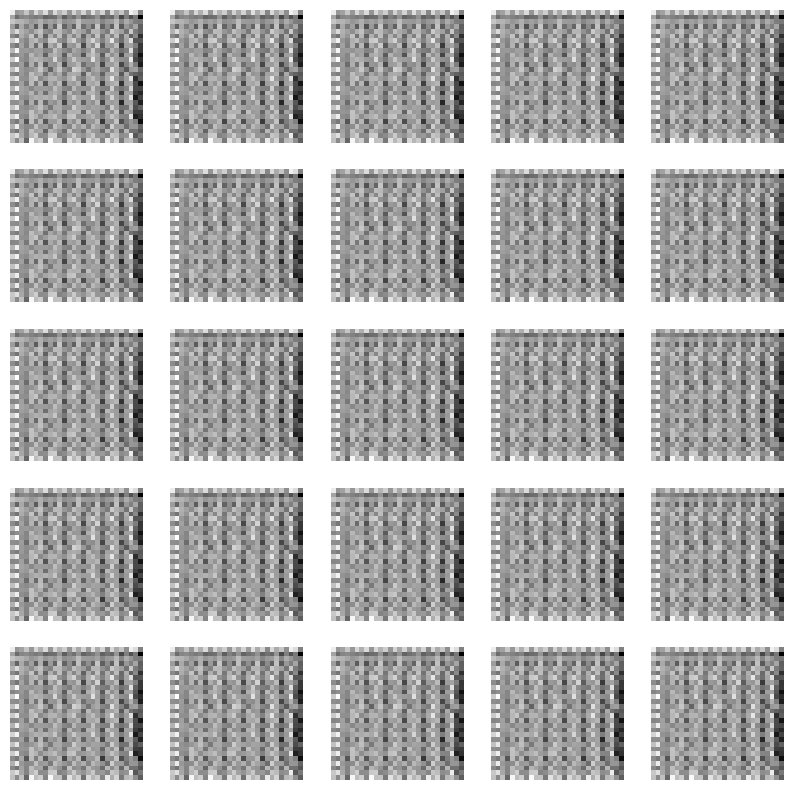

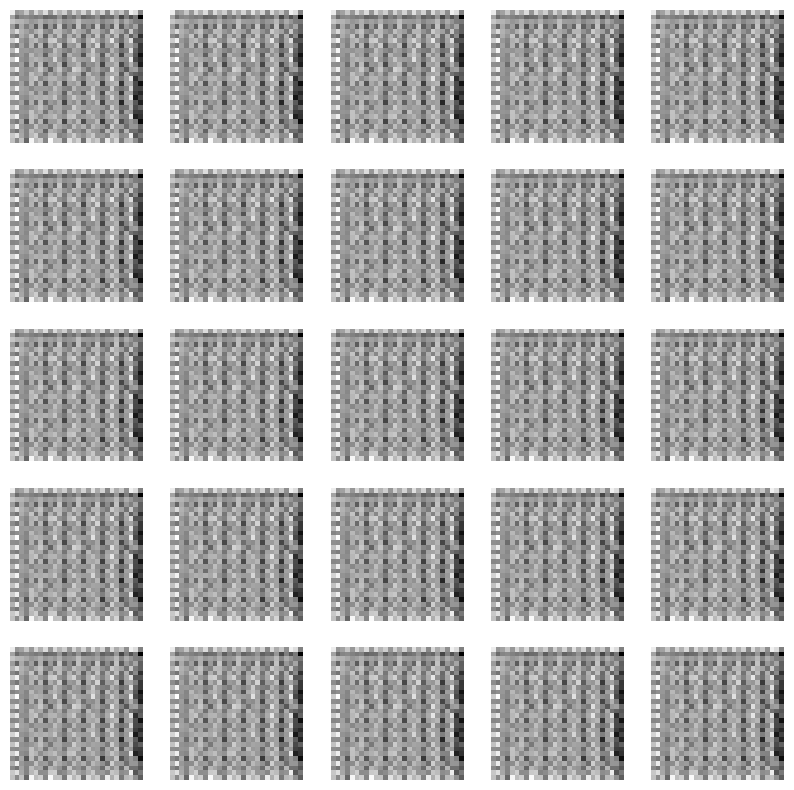

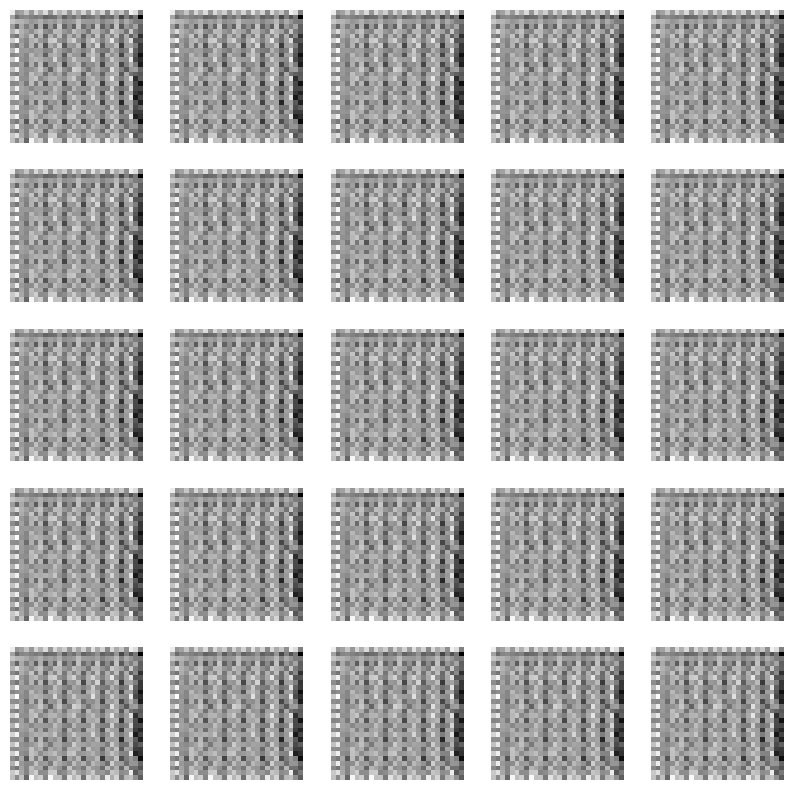

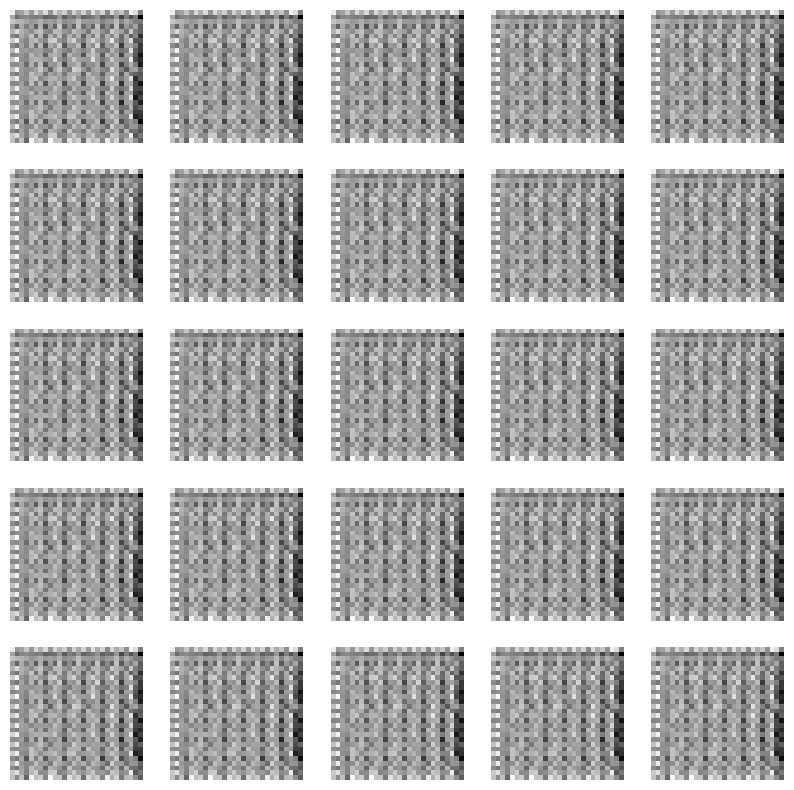

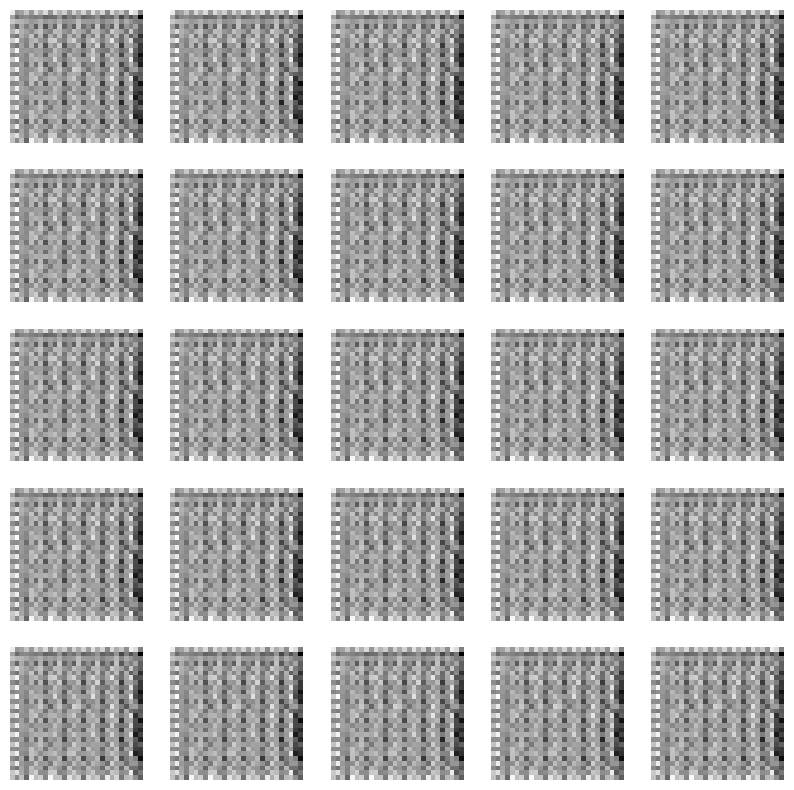

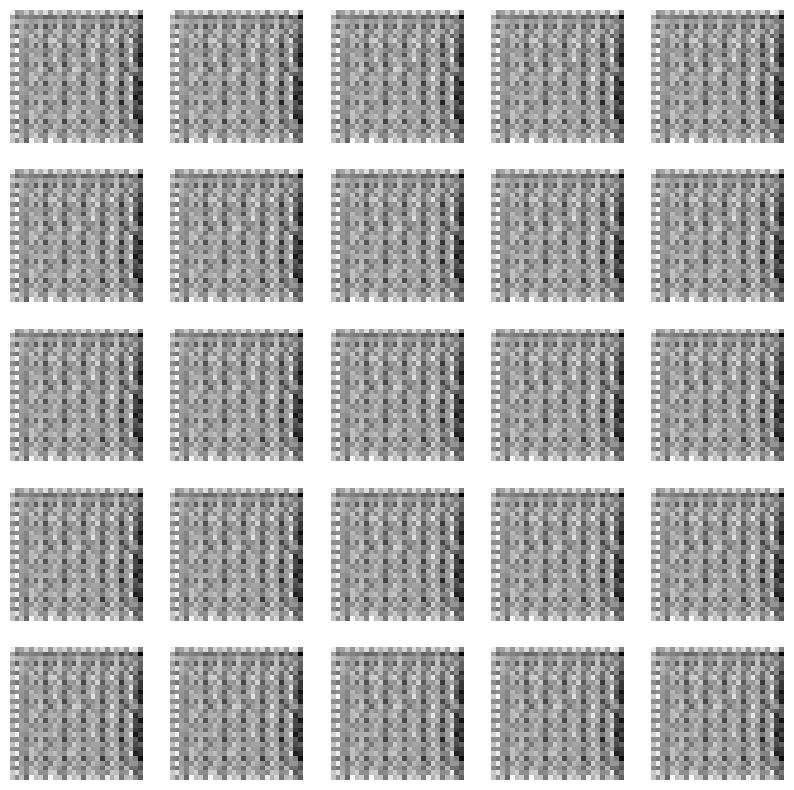

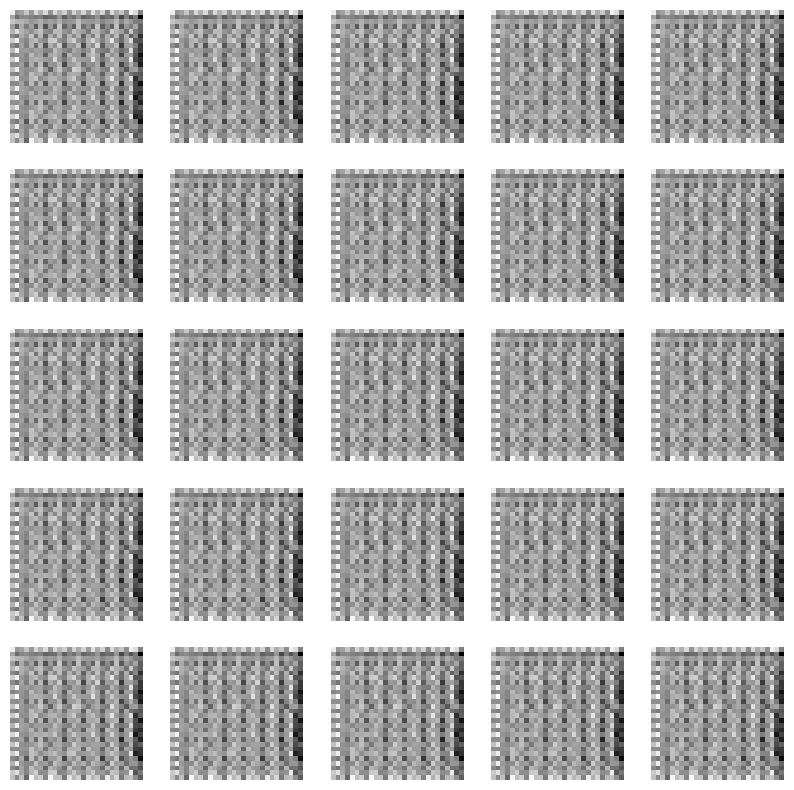

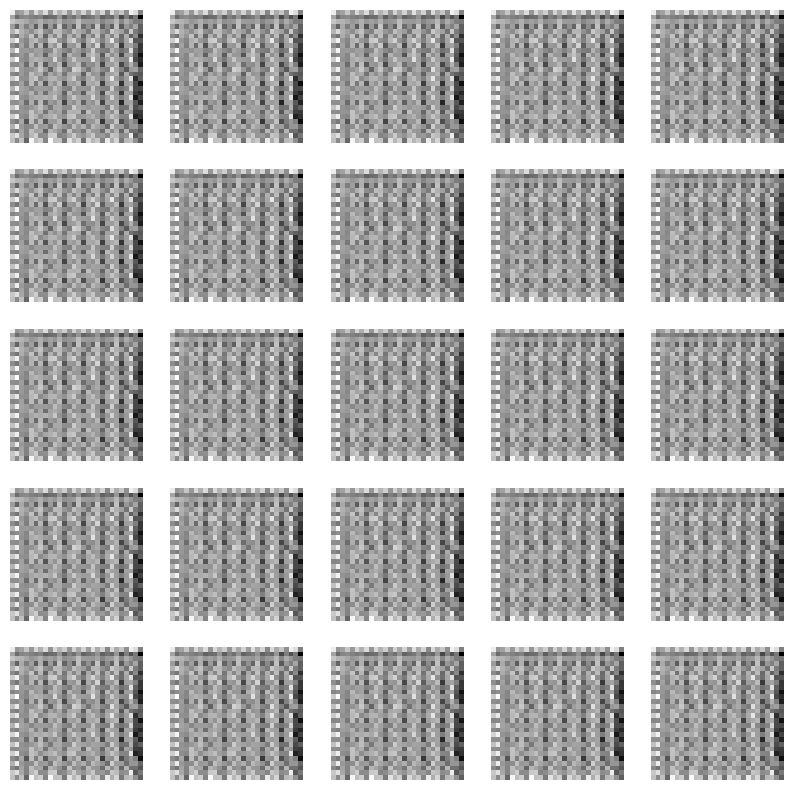

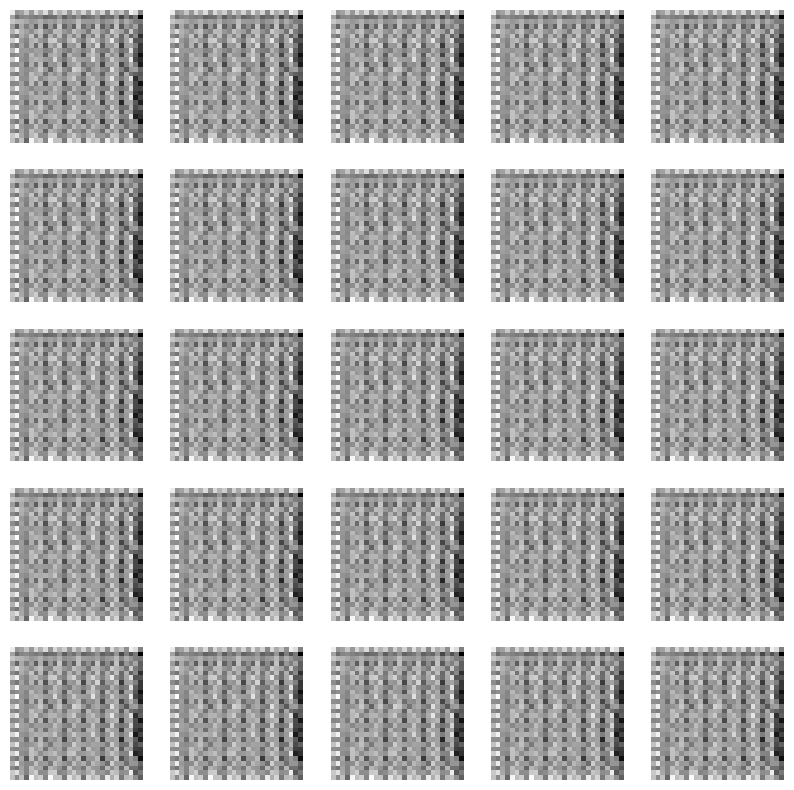

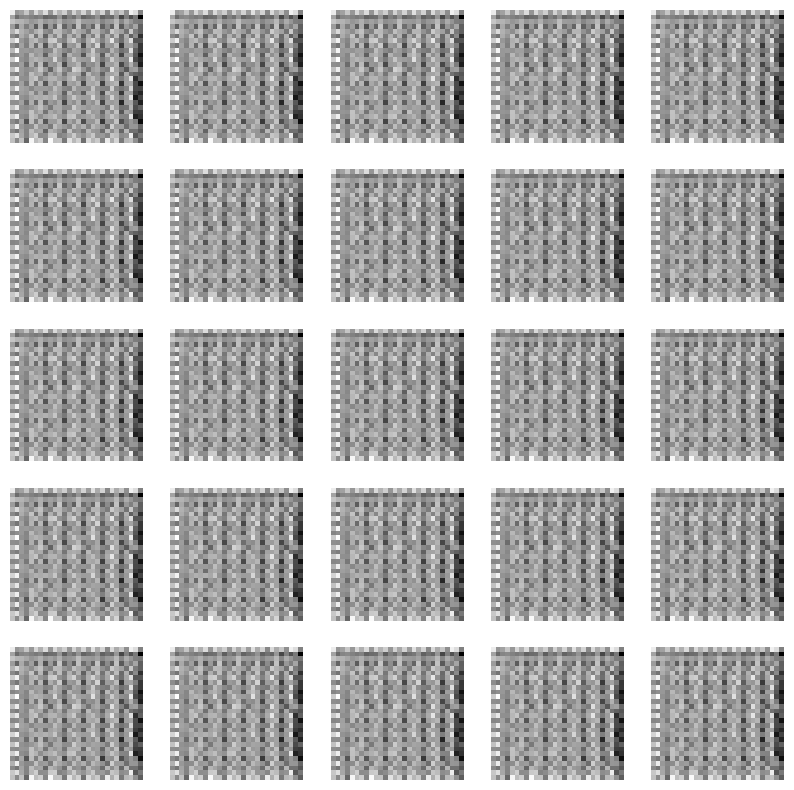

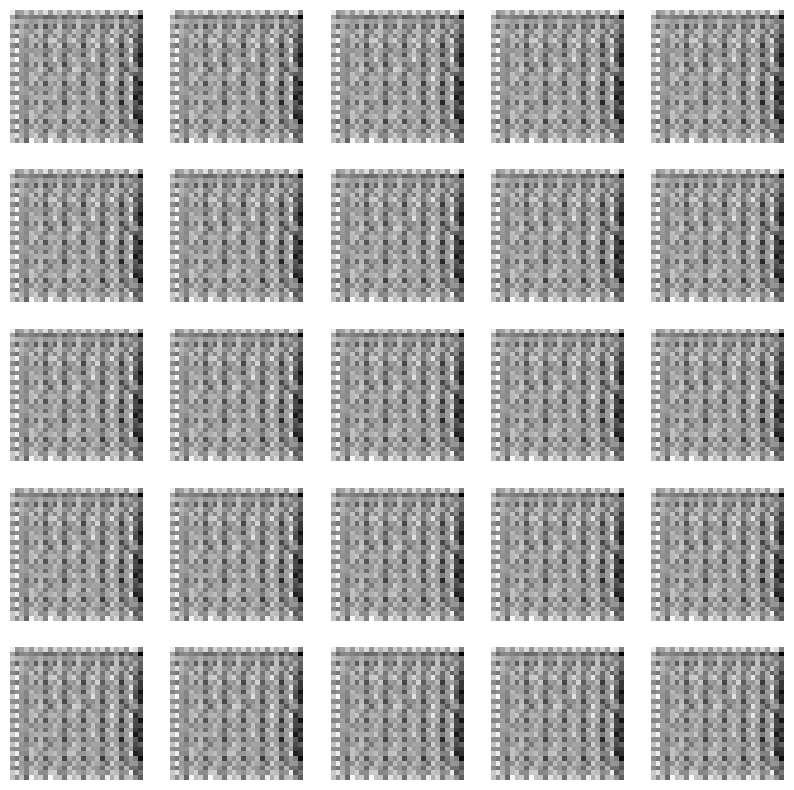

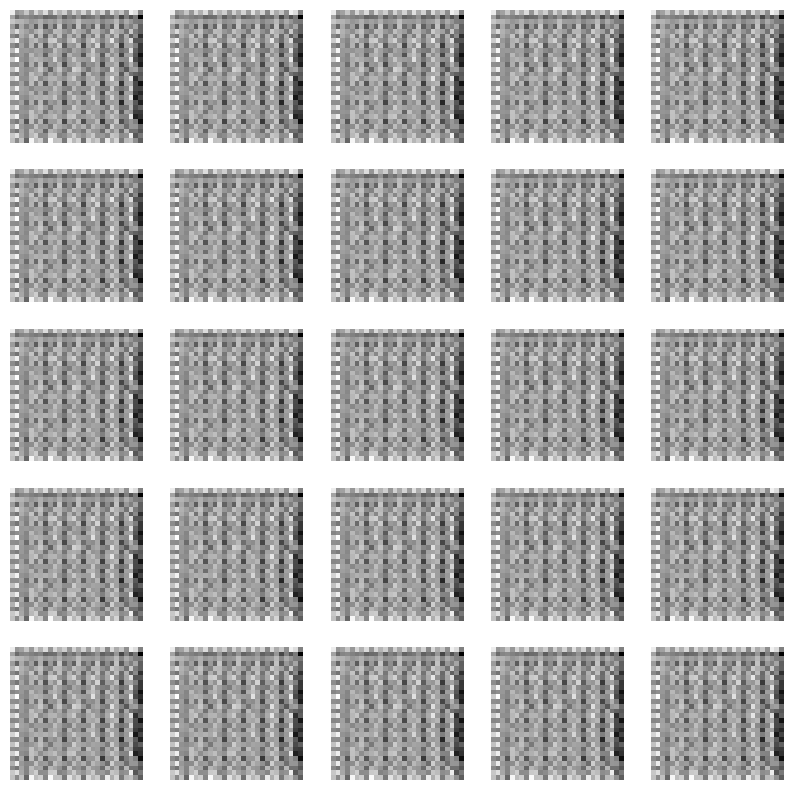

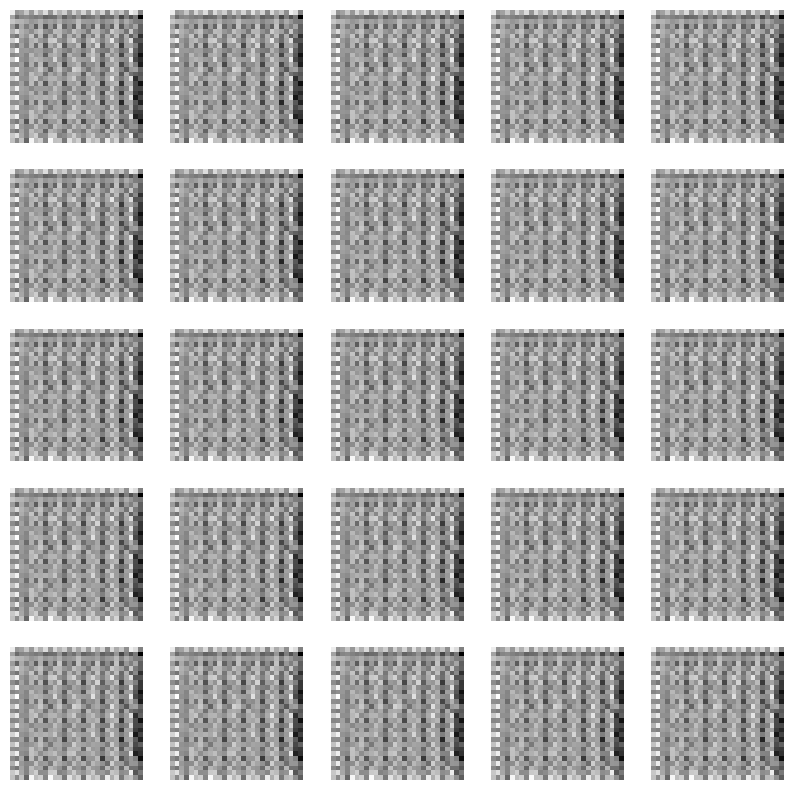

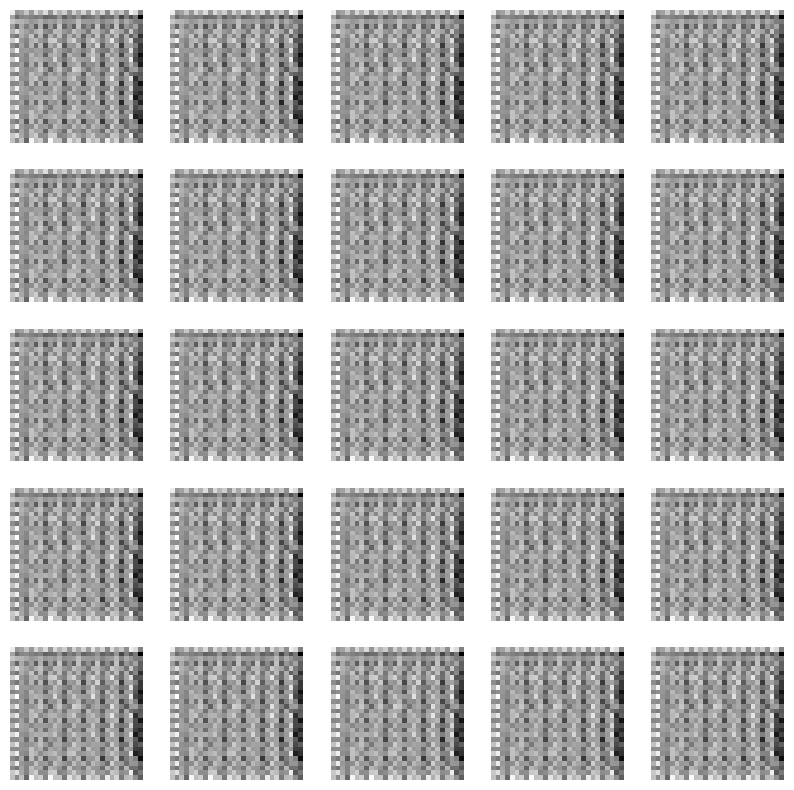

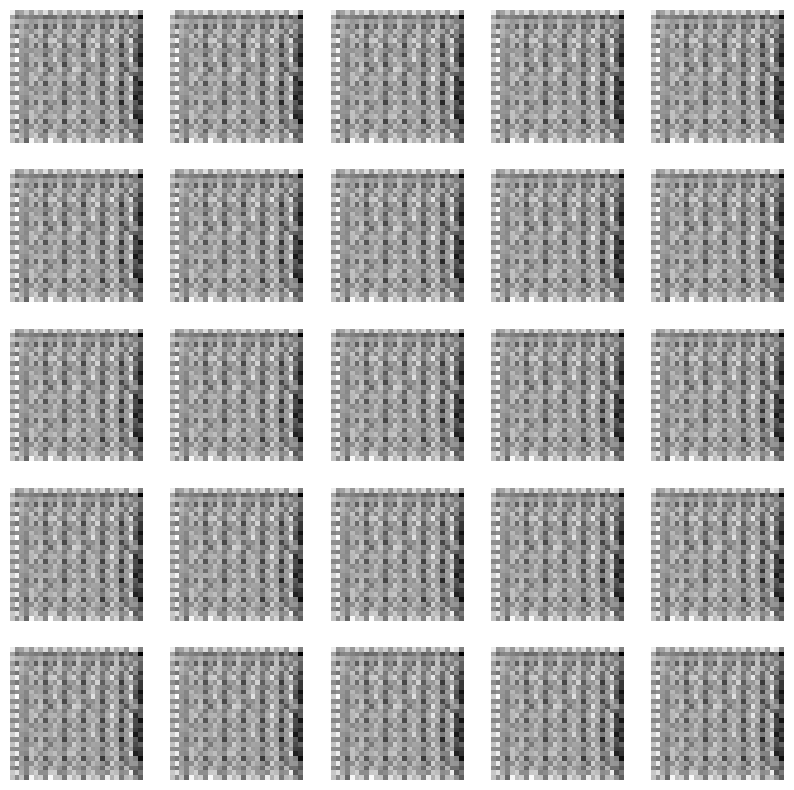

In [33]:
predict(model)

In [45]:
def predict_step(model, timesteps=50,num_samples=8):
    xs=[]
    x = np.random.normal(size=(num_samples, 28, 28, 1))

    for i in trange(timesteps):
        t = np.full((num_samples, 1), i)
        x = model.predict([x, t], verbose=0)
        if i%5 ==0:
            xs.append(x[0])
    xs = [(x - x.min()) / (x.max() - x.min()) for x in xs]

    plt.figure(figsize=(20, 3))
    for i, img in enumerate(xs):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(cvtImg(img), cmap='gray')
        plt.title(f'Step {i*5}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

100%|██████████| 50/50 [00:05<00:00,  9.50it/s]


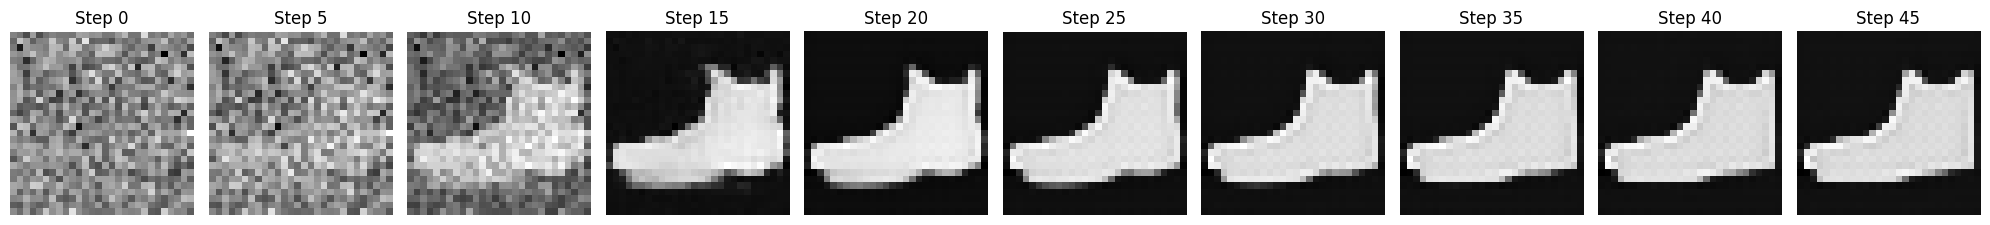

In [46]:
predict_step(model)

In [43]:
def train_one(x_img):
    x_ts = generate_ts(len(x_img))
    x_a,x_b = forward_noise(x_img,x_ts)
    loss = model.train_on_batch([x_a, x_ts],x_b)
    return loss

In [44]:
def train(R=50):
    bar= trange(R)
    total = 100

    for i in bar:
        for j in range(total):
            x_img = X_treino[np.random.randint(len(X_treino), size=BATCH_SIZE)]
            loss = train_one(x_img)
            pg = (j/total)*100
            if j%5 ==0:
                bar.set_description(f'loss: {loss:.5f}, p:{pg:.2f}%')


In [38]:
train()

loss: 0.03024, p:95.00%: 100%|██████████| 50/50 [1:44:55<00:00, 125.92s/it]


In [47]:
def predict(model, timesteps=50, batch_size=32):
    x = np.random.normal(size=(batch_size, 28, 28, 1))

    for i in trange(timesteps):
        t = np.full((batch_size, 1), i)
        x = model.predict([x, t], verbose=0)

        x = (x-x.min())/(x.max()-x.min())
        show_examples(x)

 40%|████      | 20/50 [00:09<00:11,  2.55it/s]C:\Users\nakaj\AppData\Local\Temp\ipykernel_14464\3853096967.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,10))
100%|██████████| 50/50 [00:21<00:00,  2.32it/s]


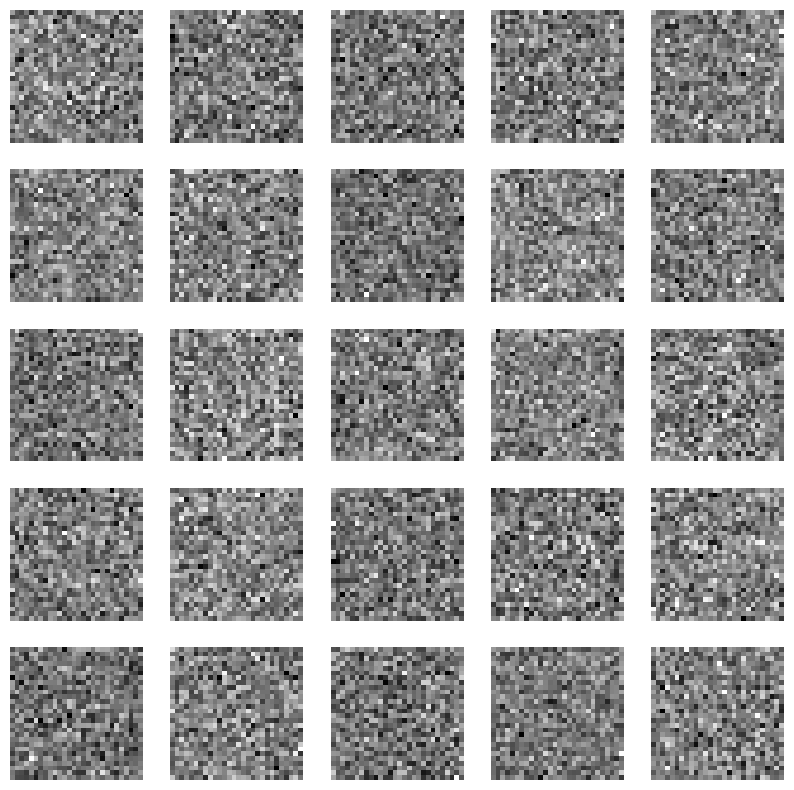

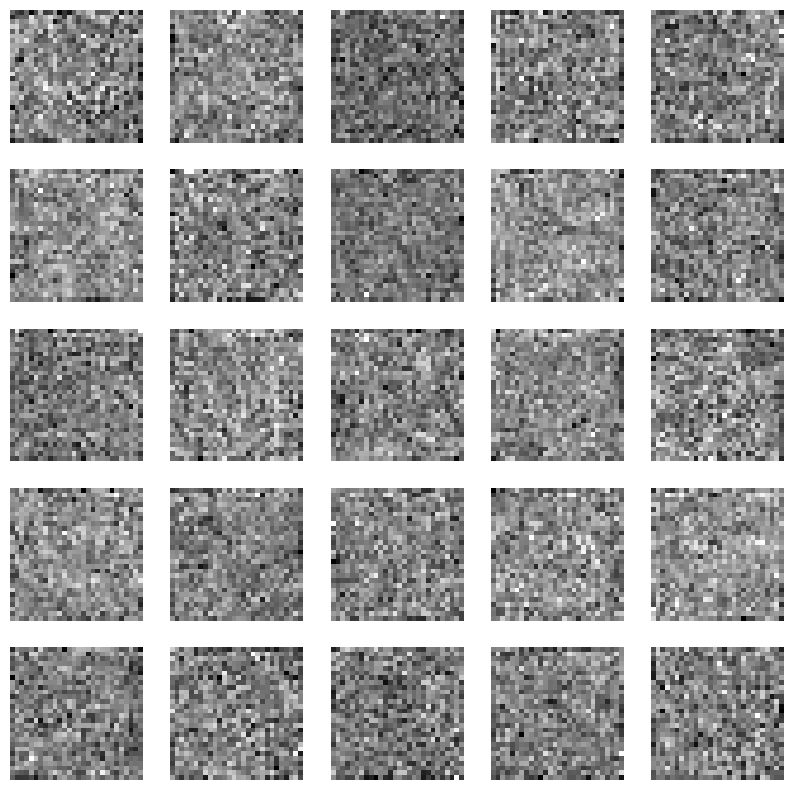

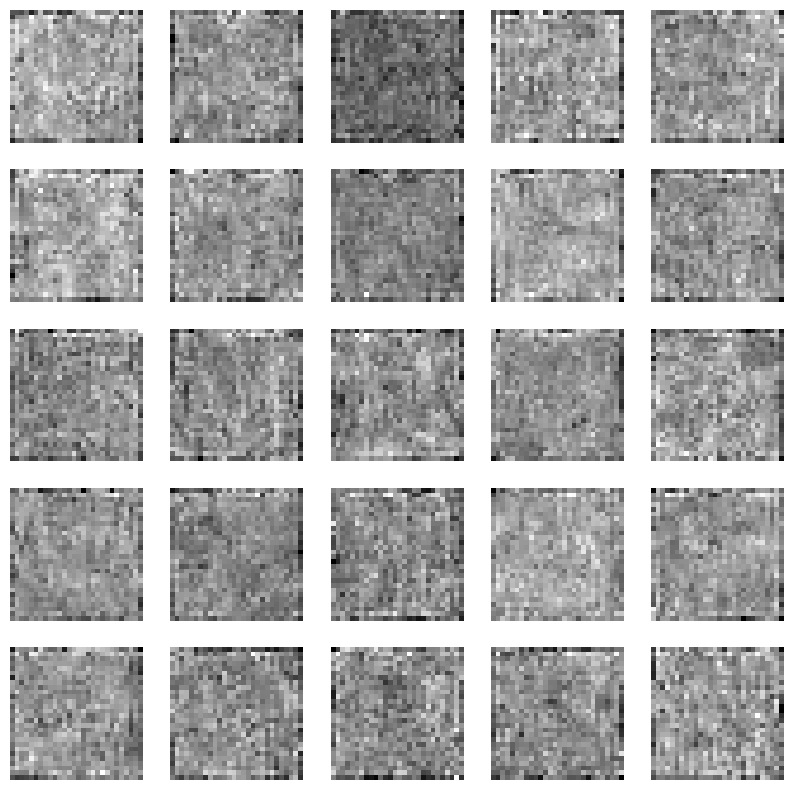

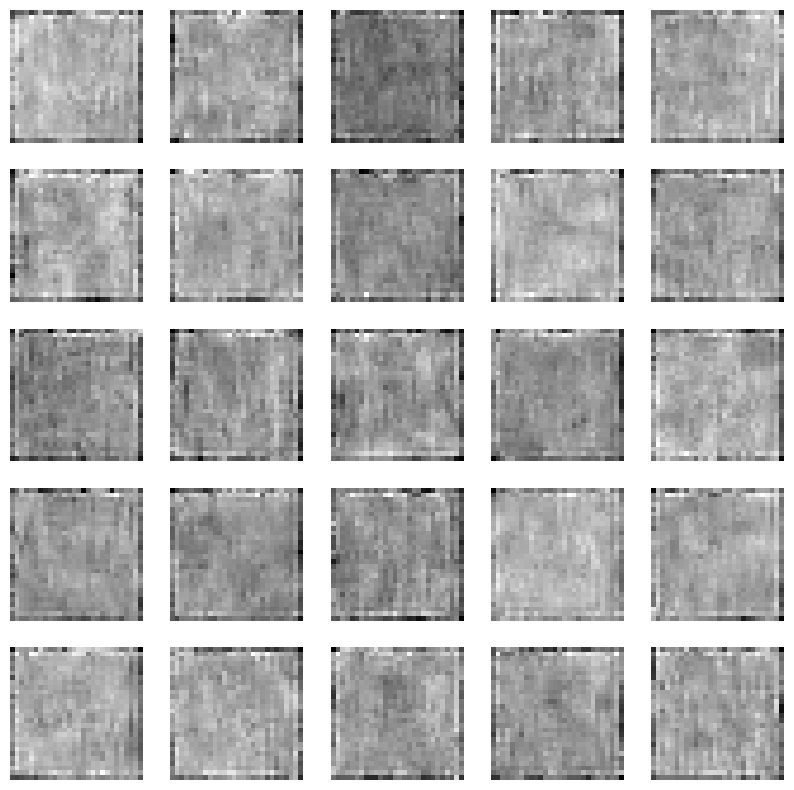

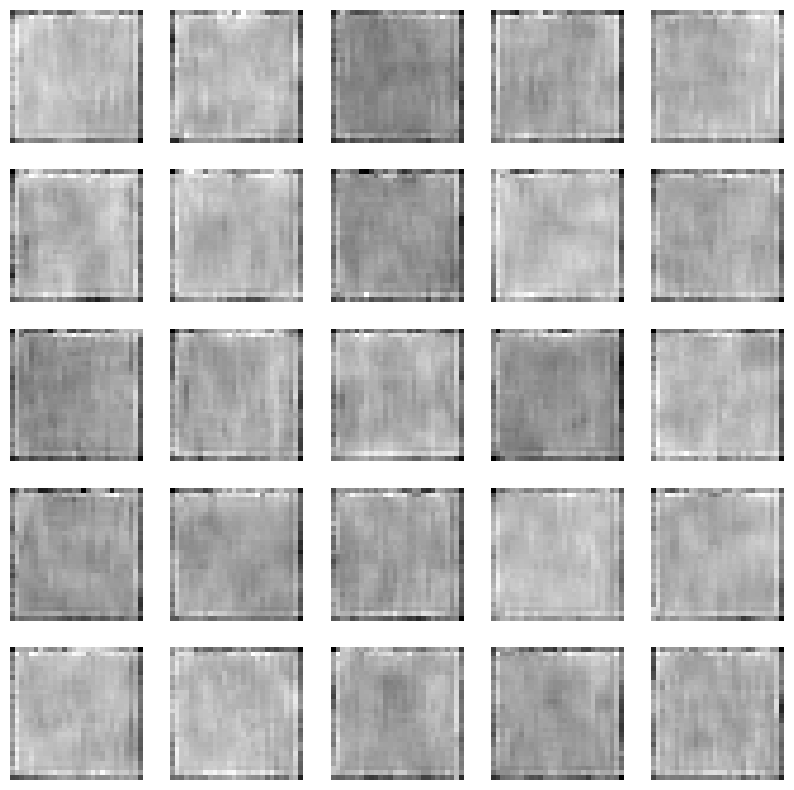

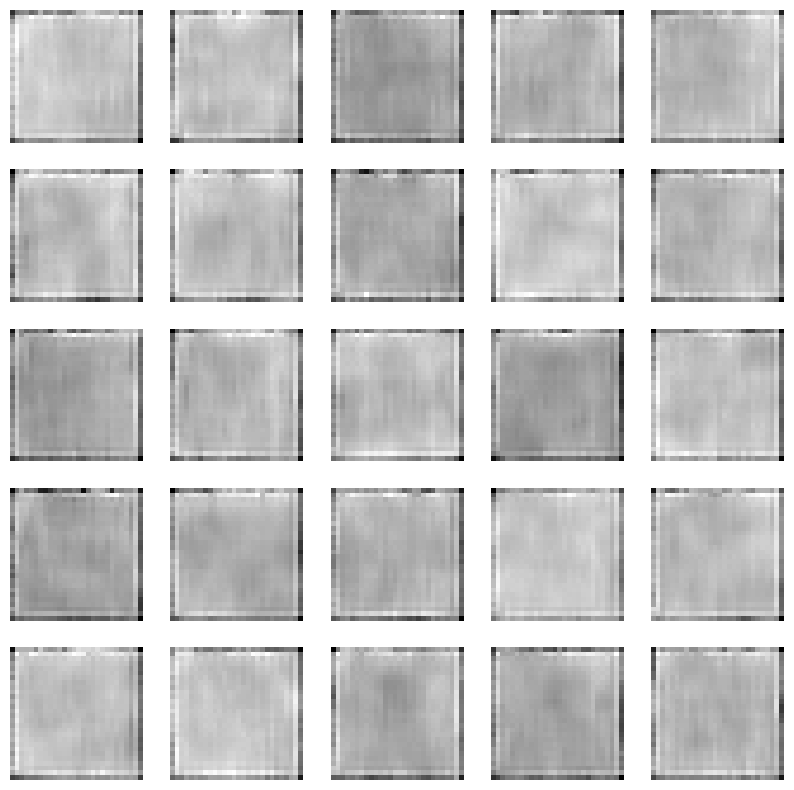

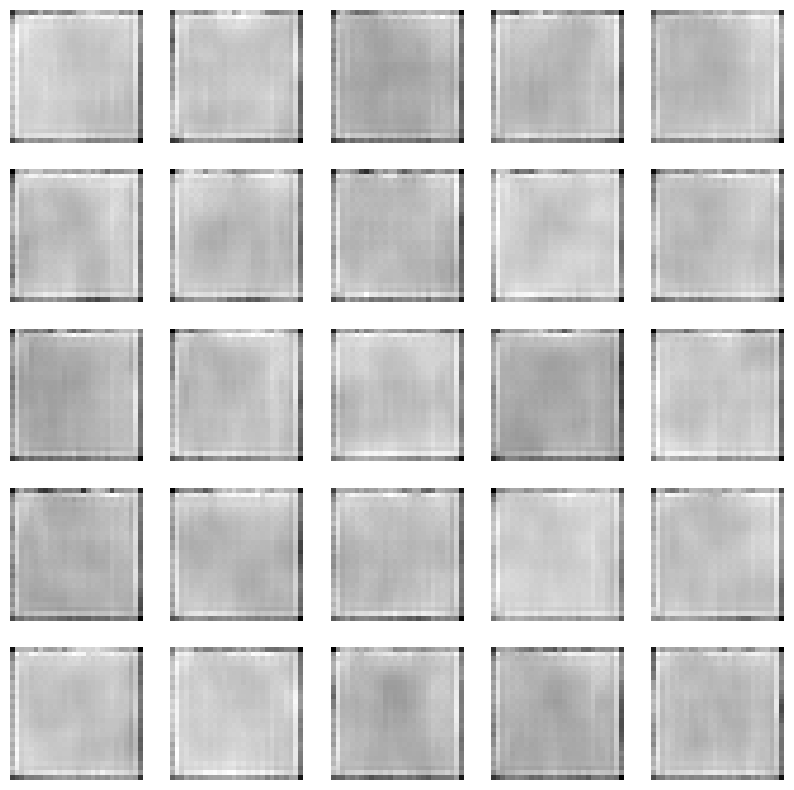

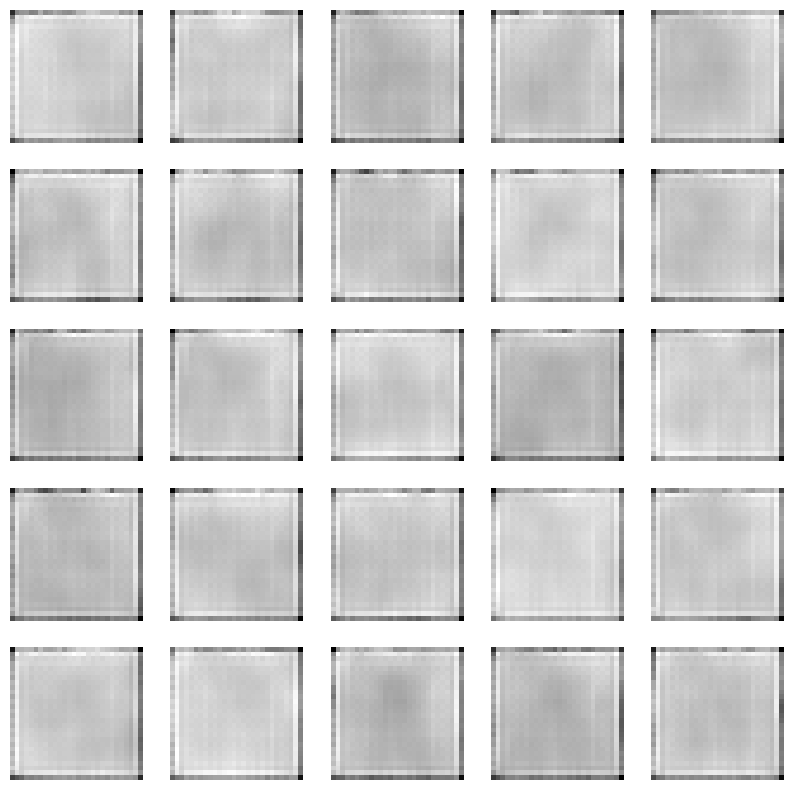

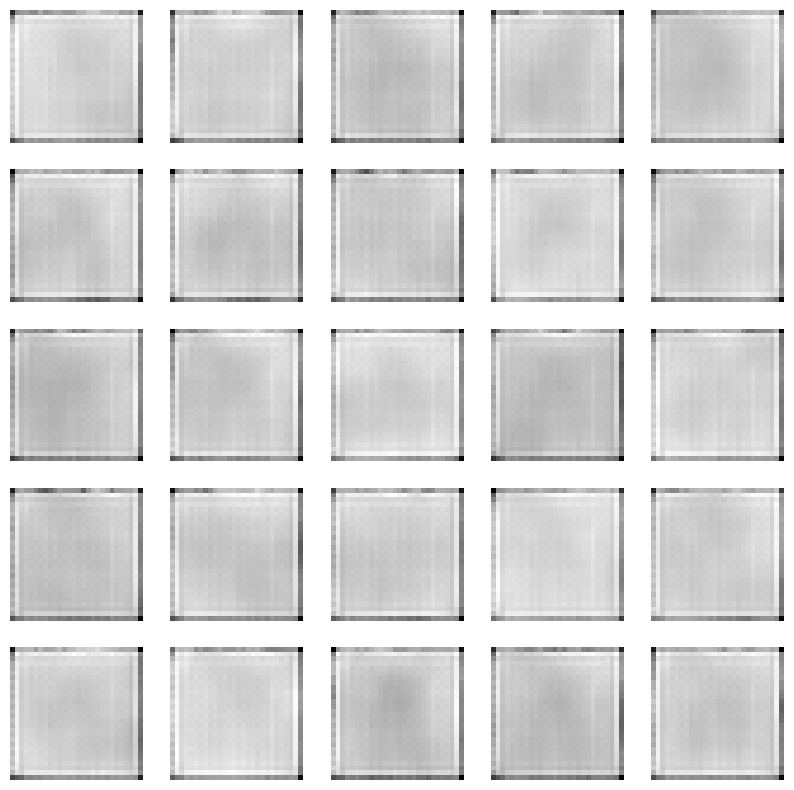

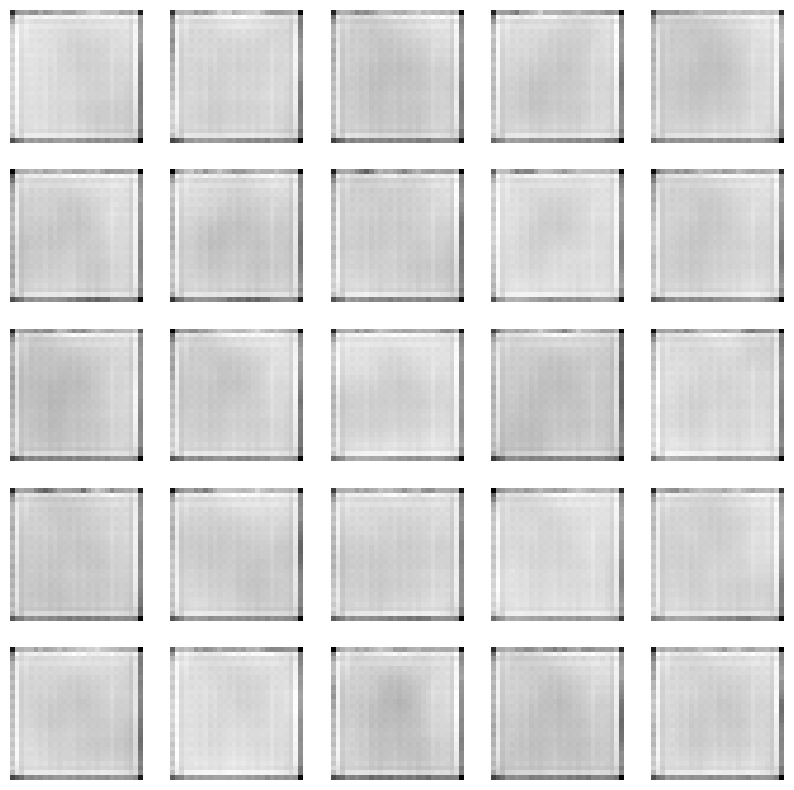

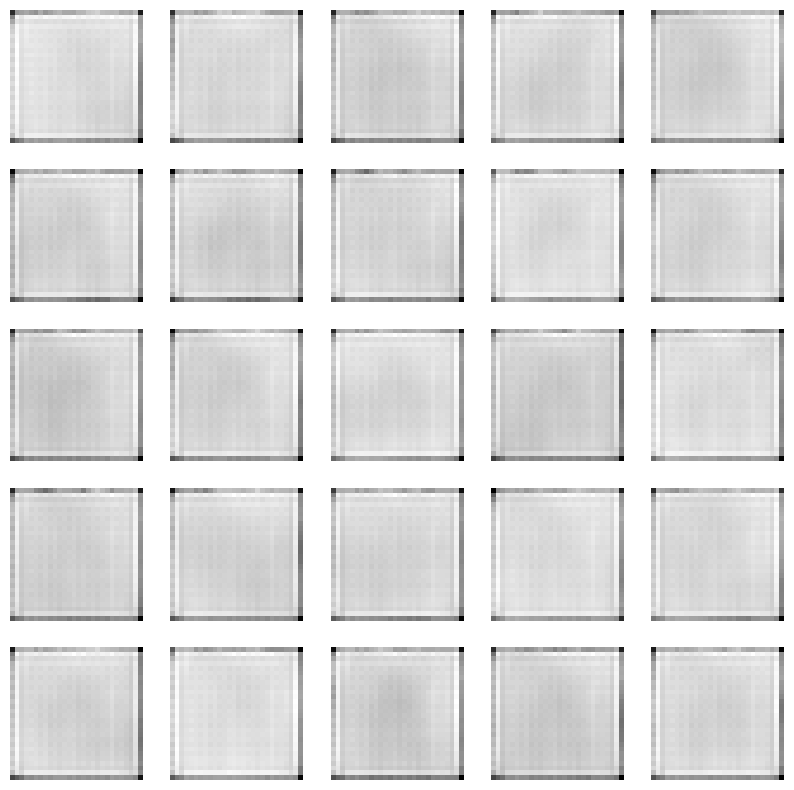

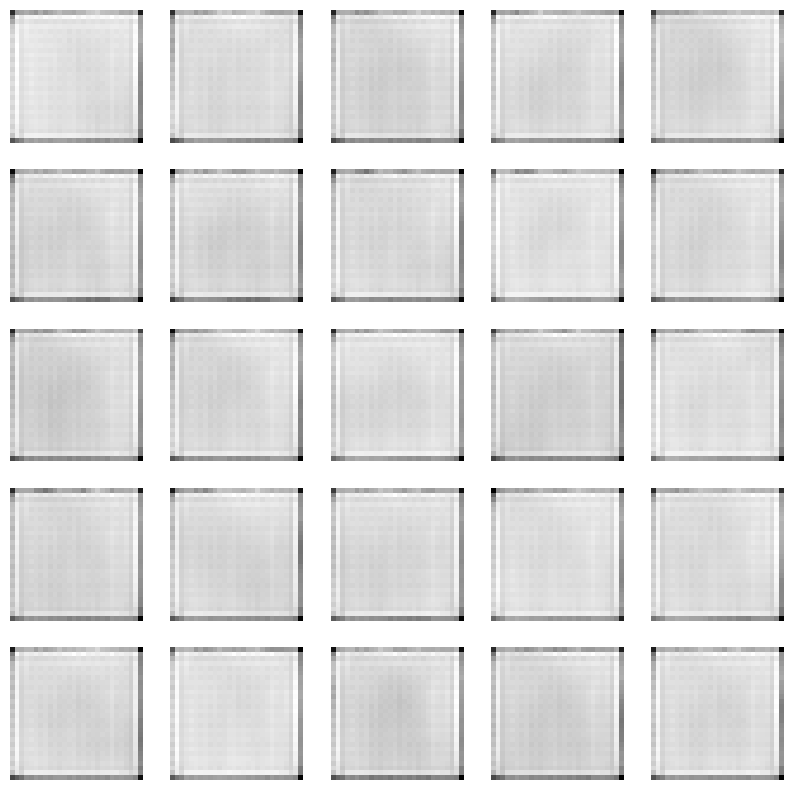

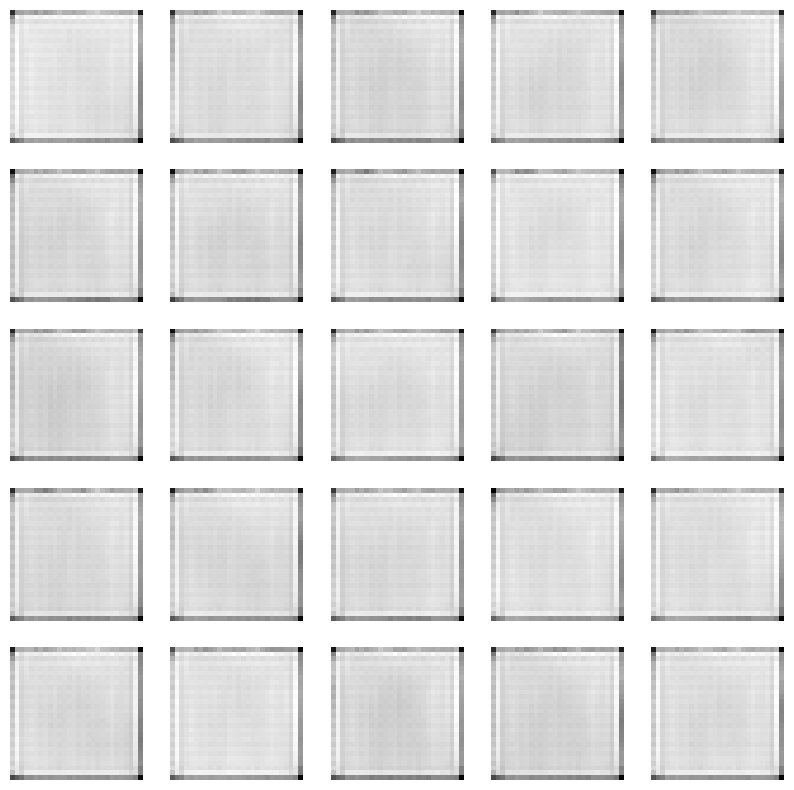

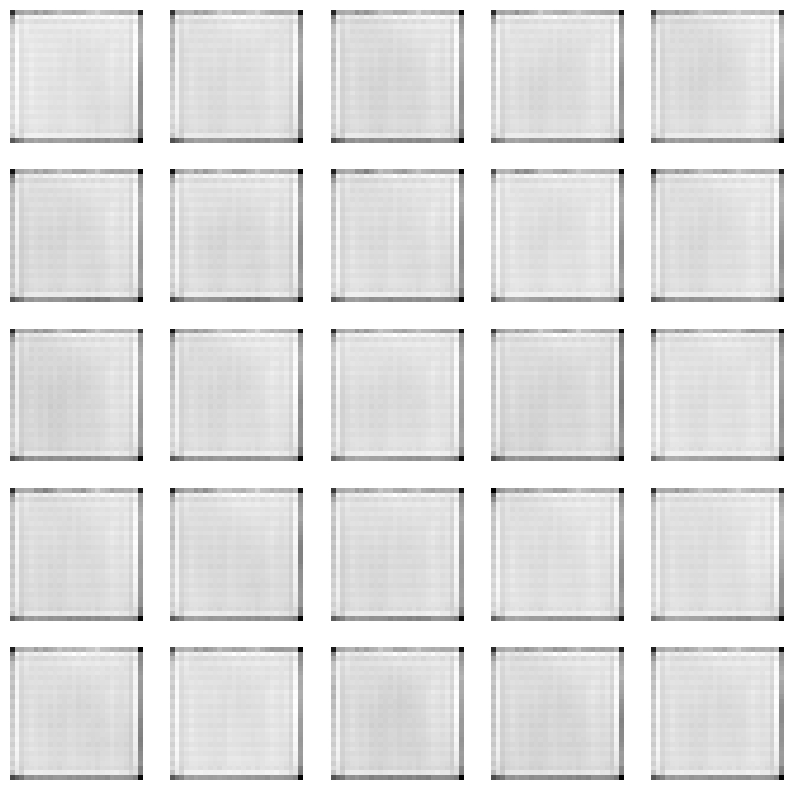

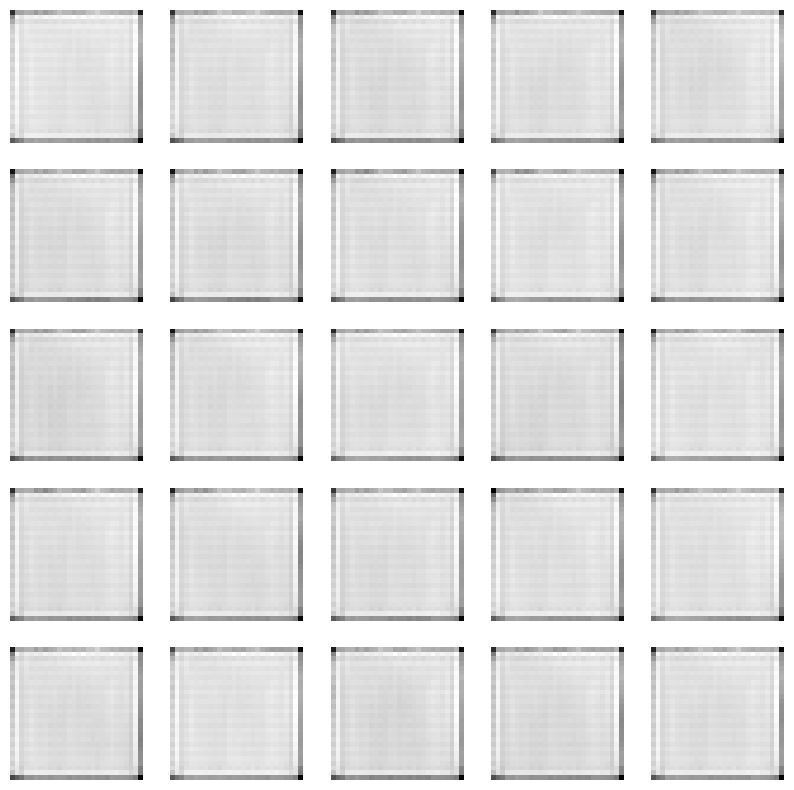

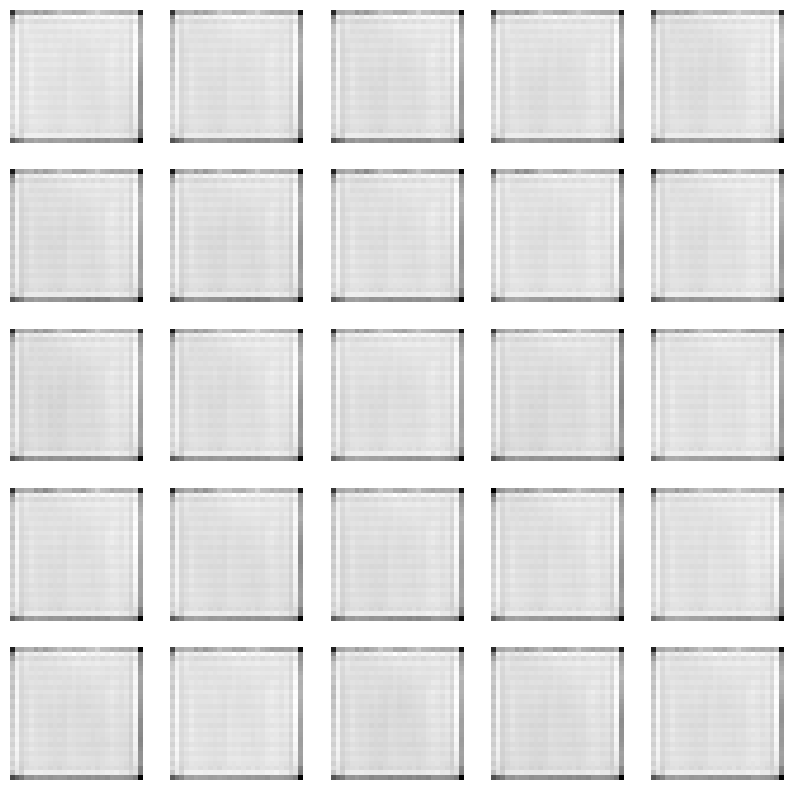

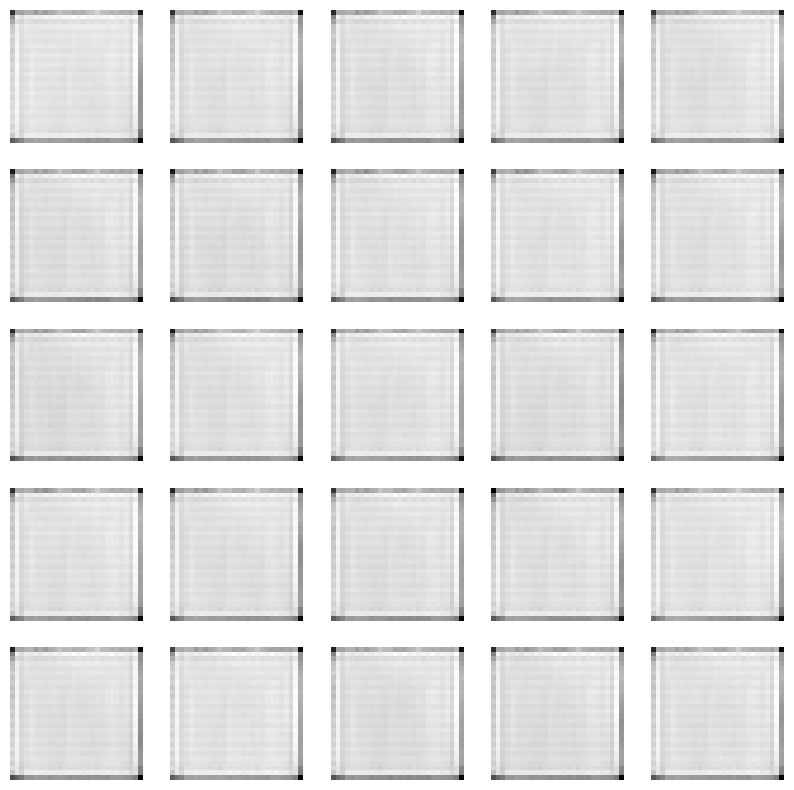

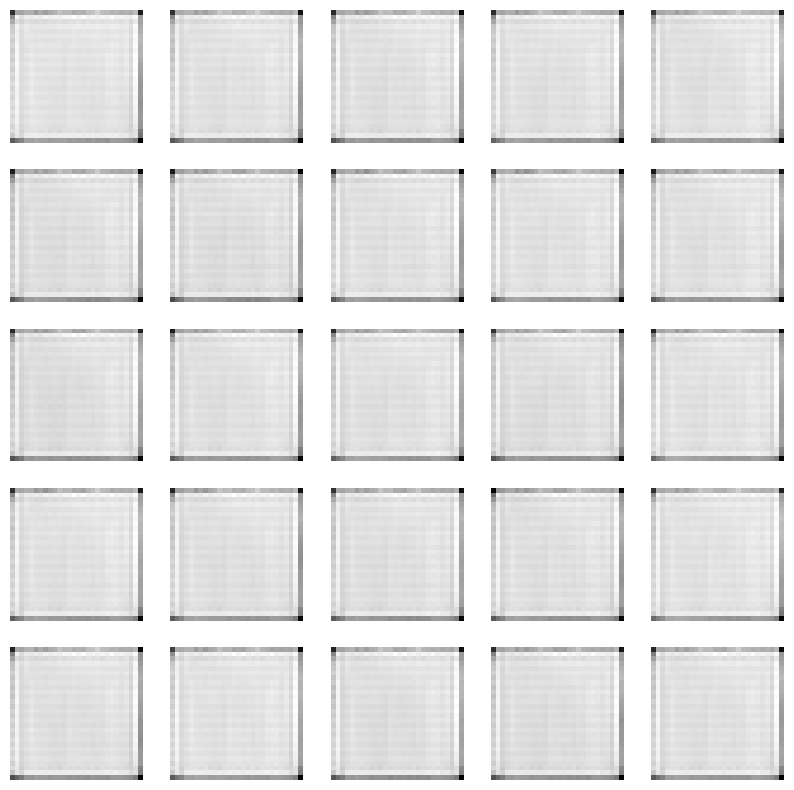

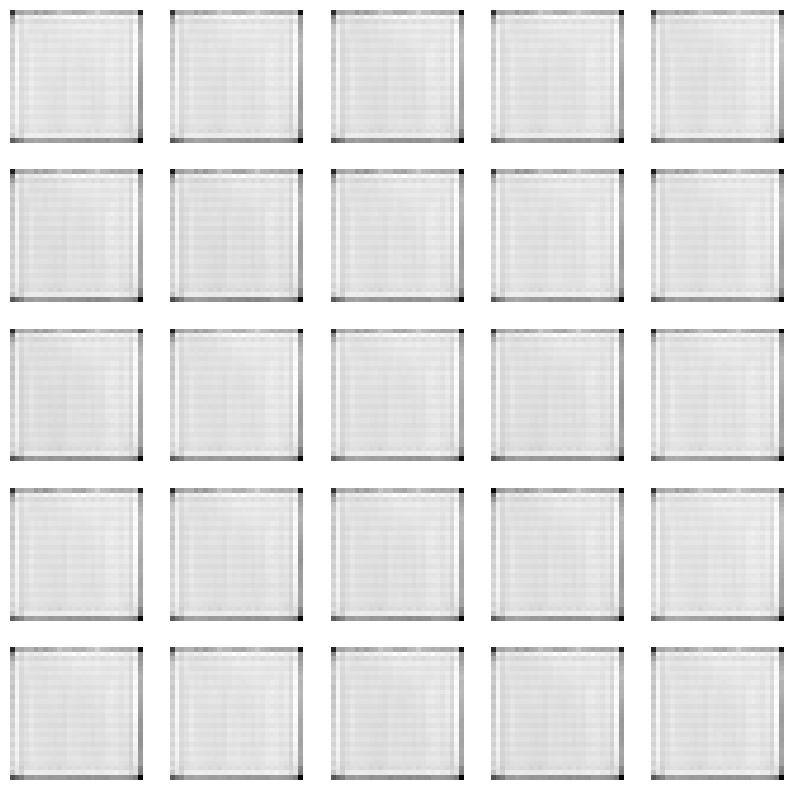

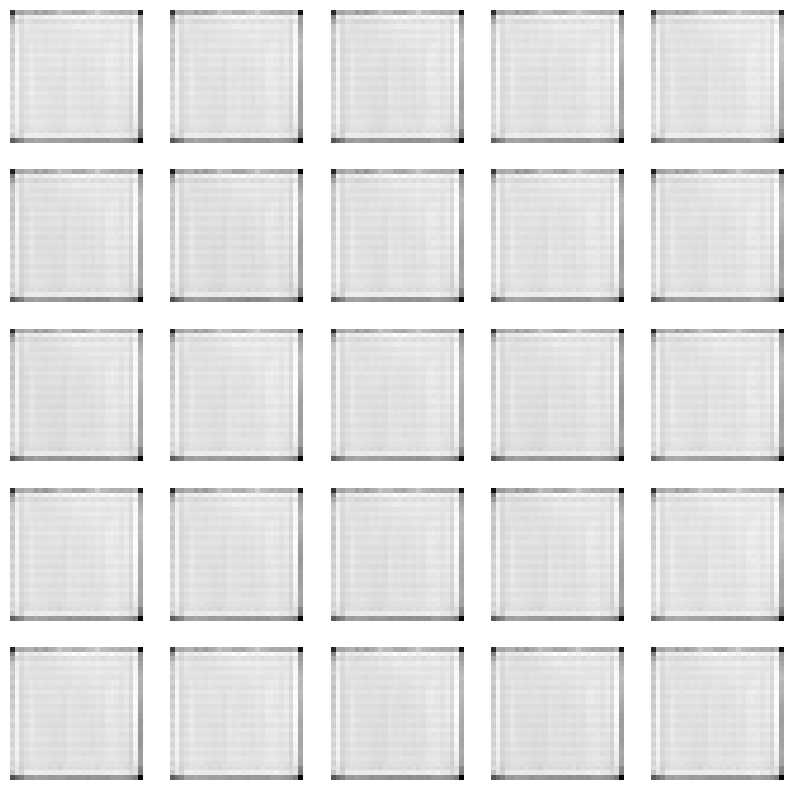

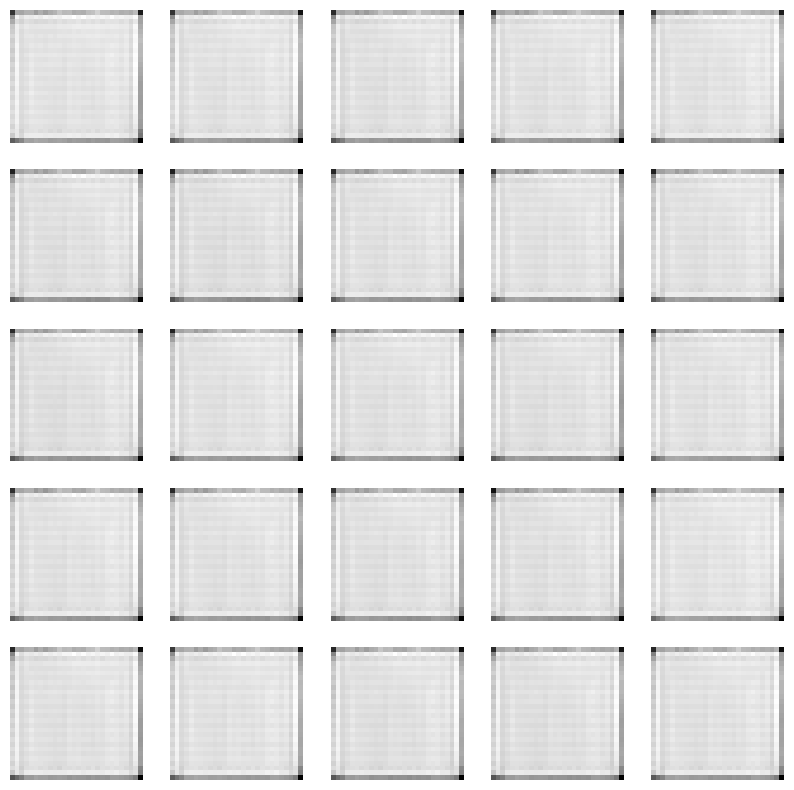

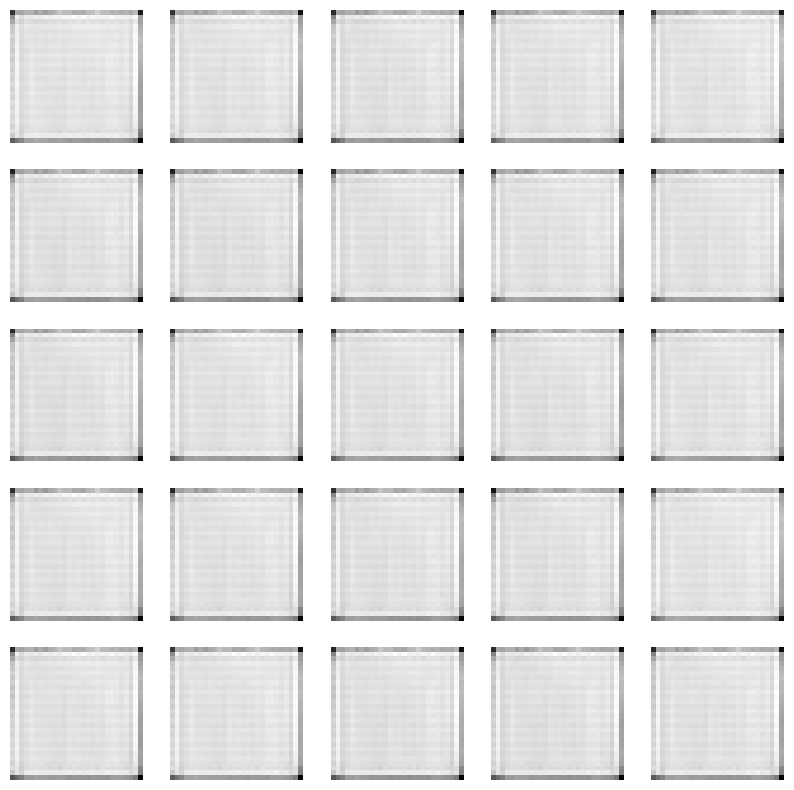

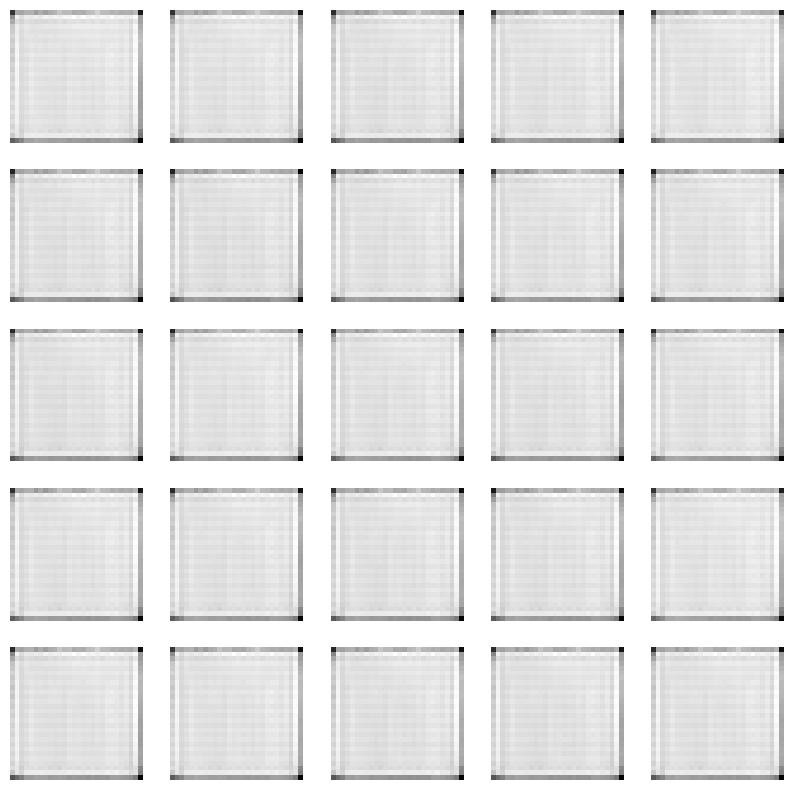

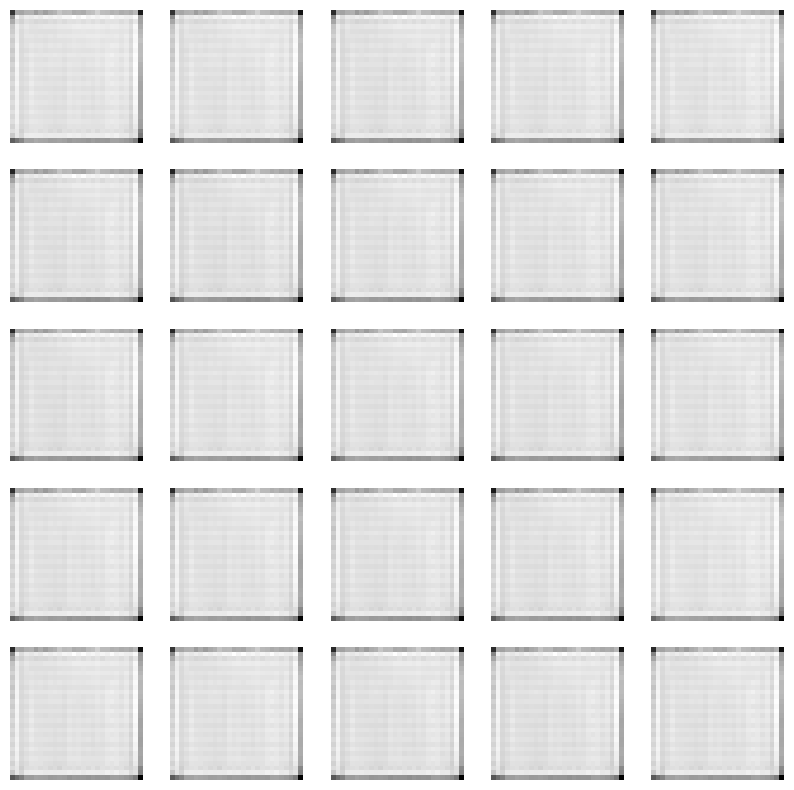

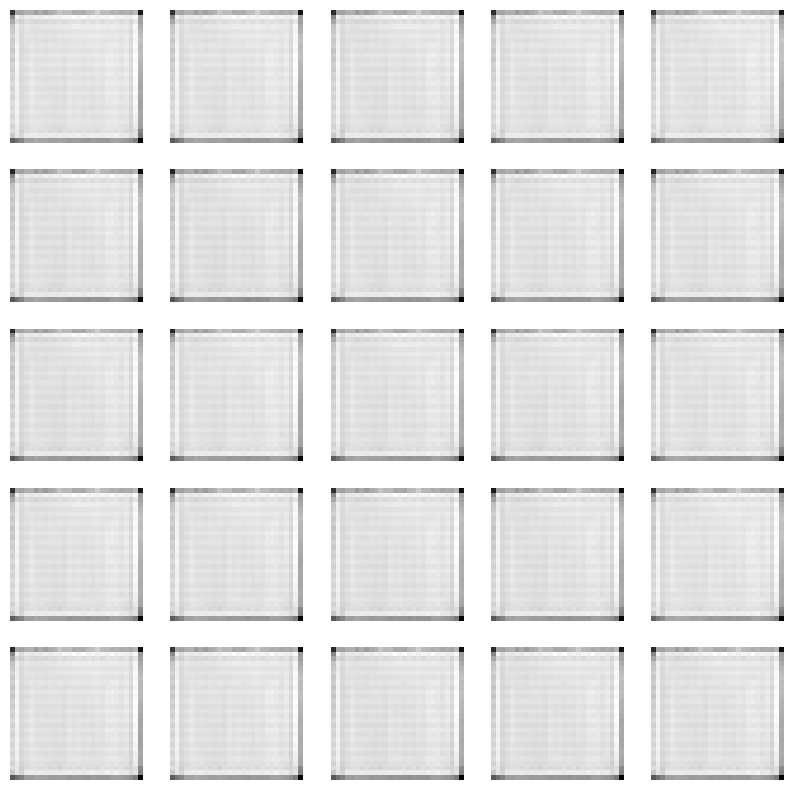

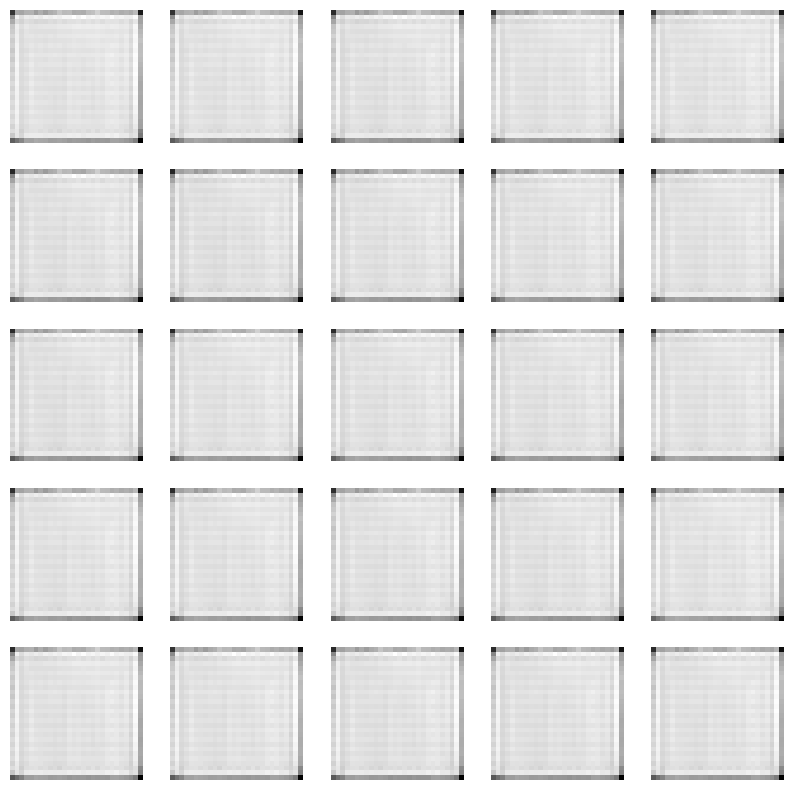

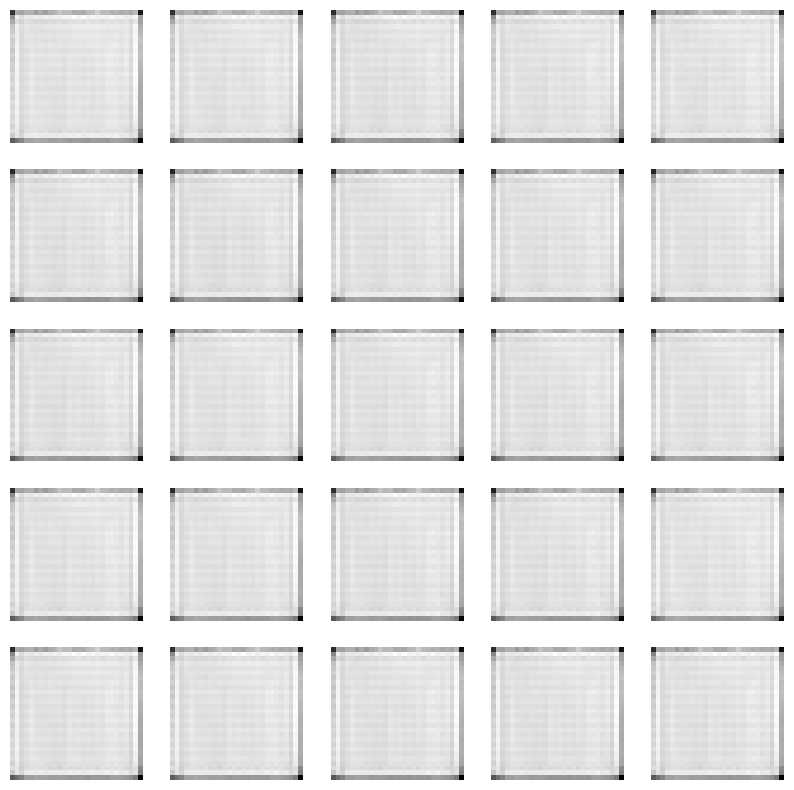

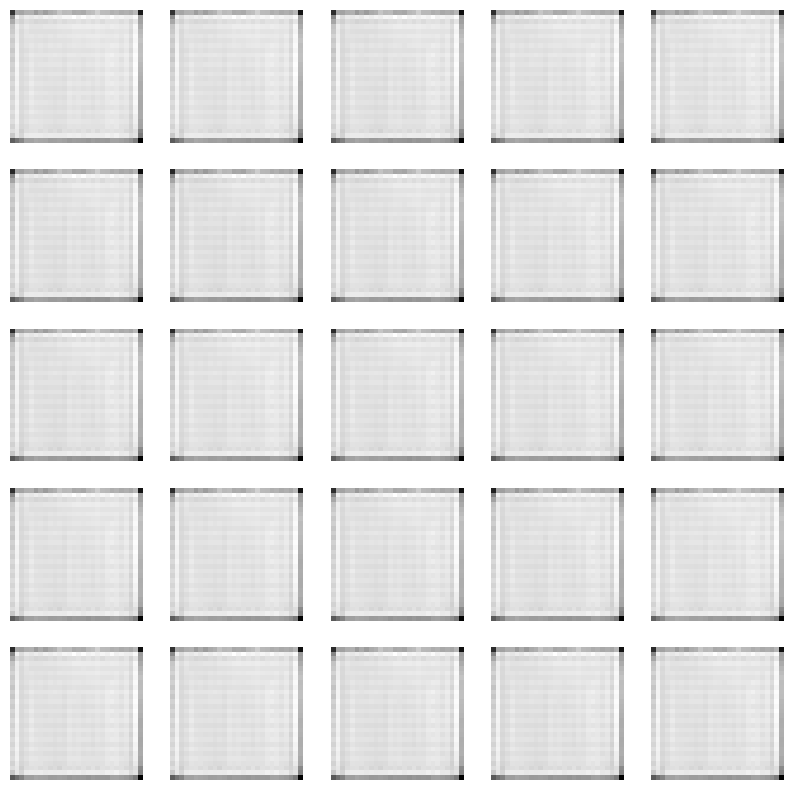

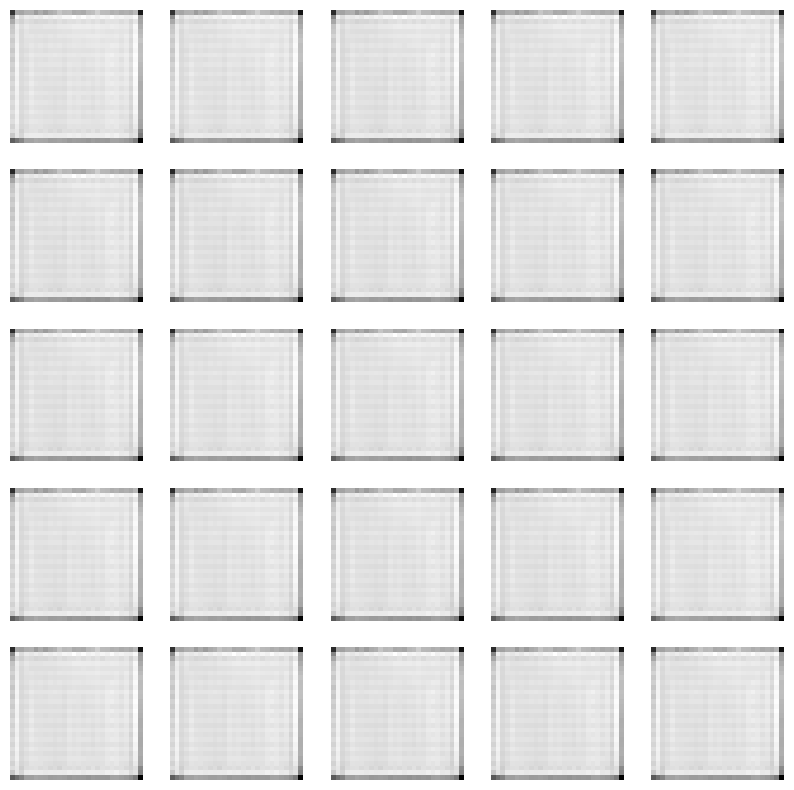

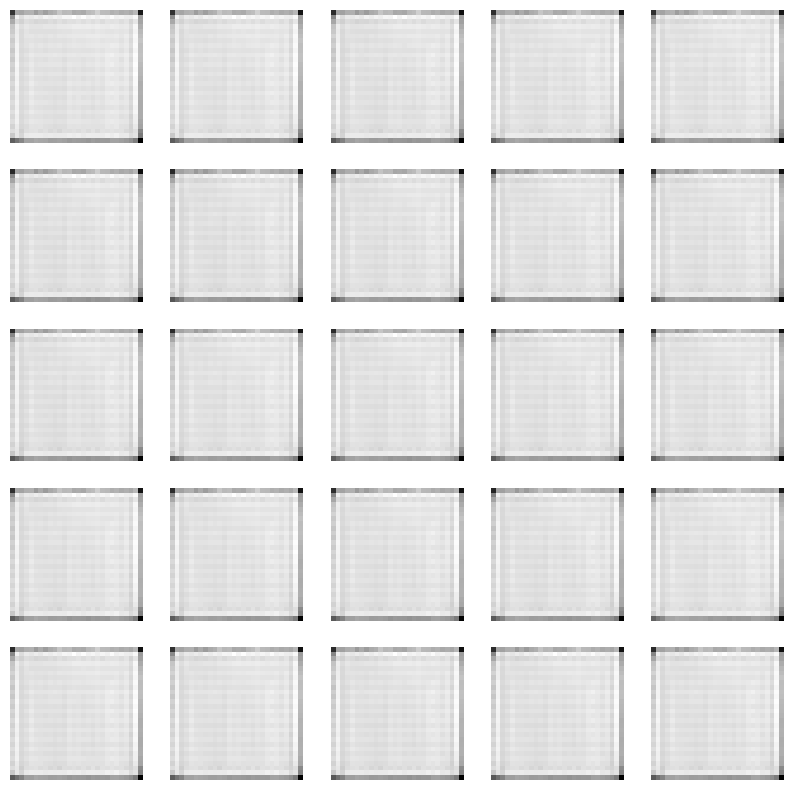

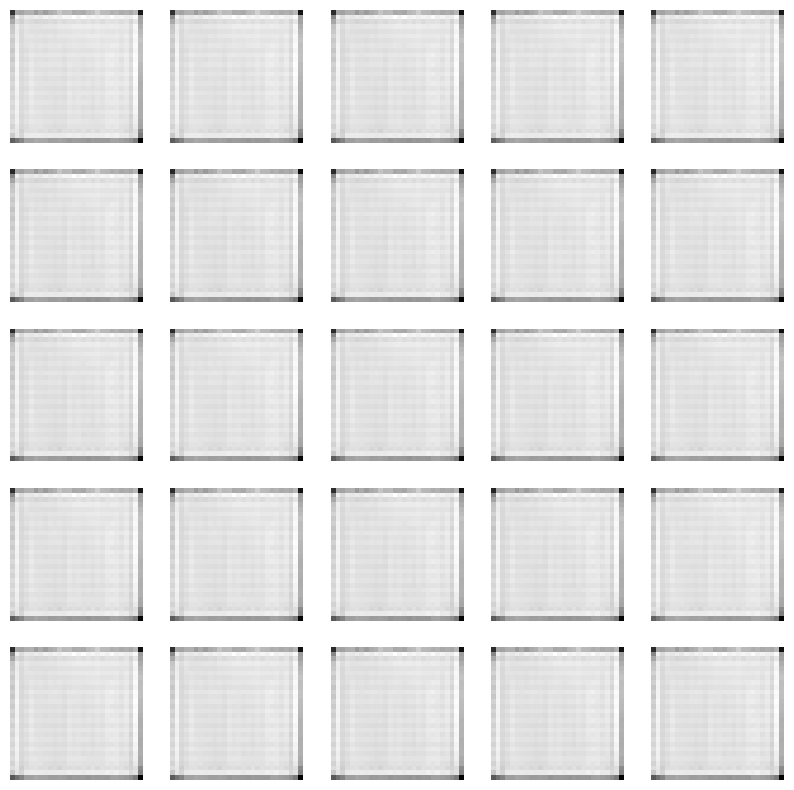

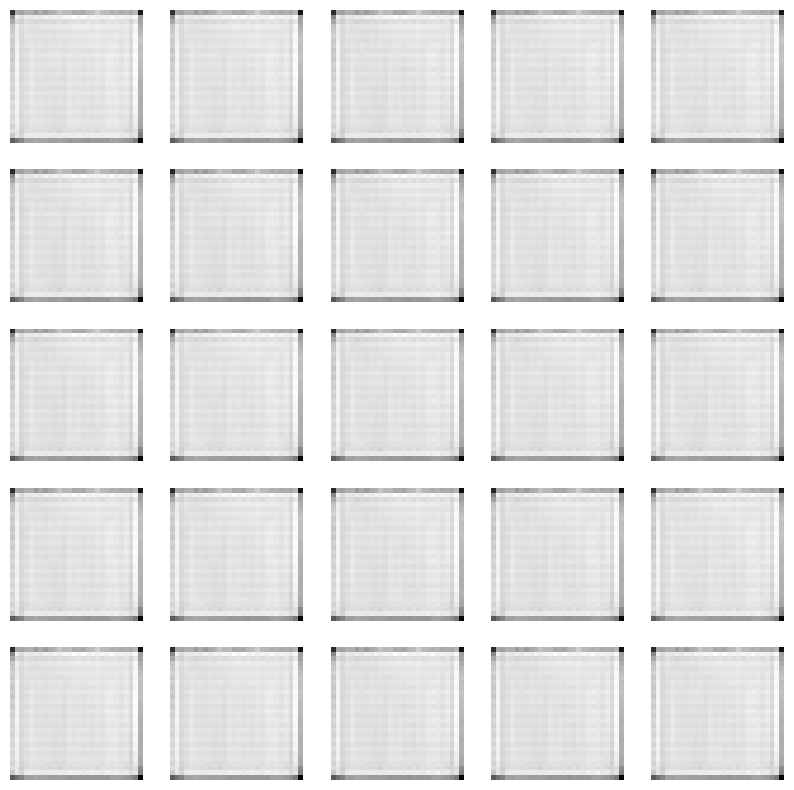

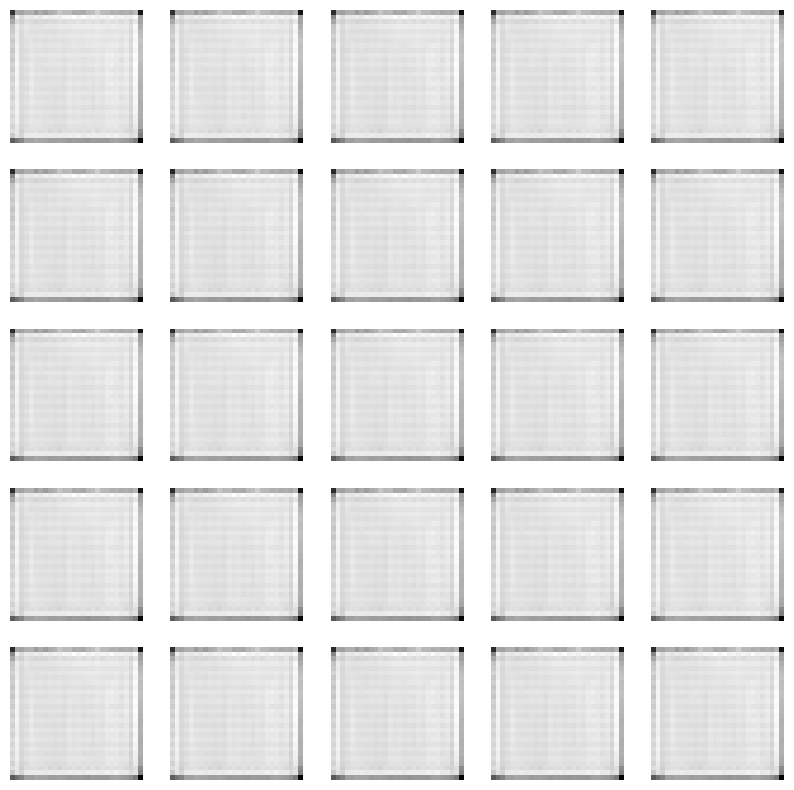

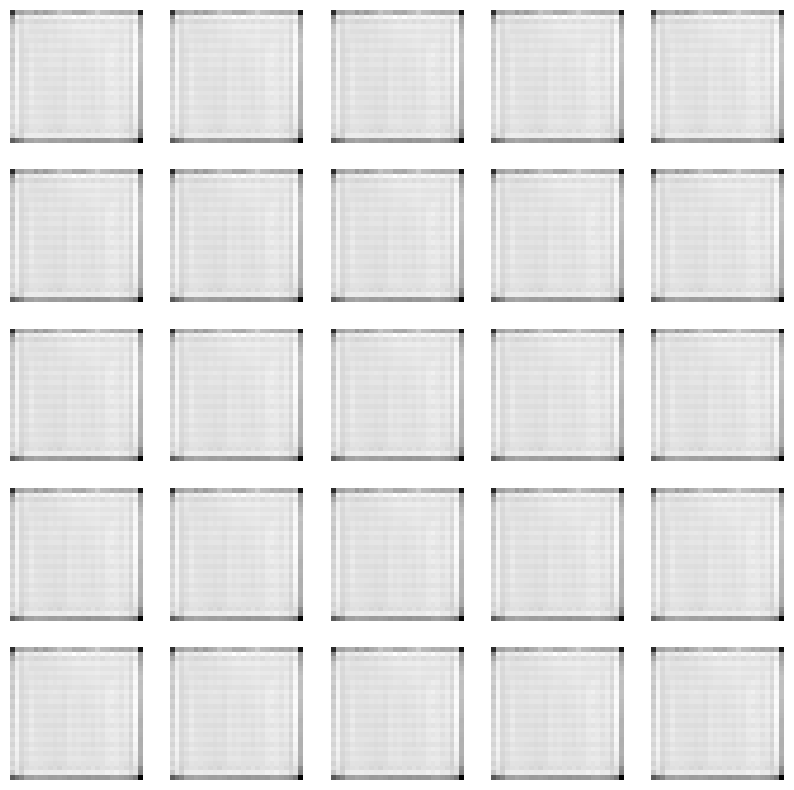

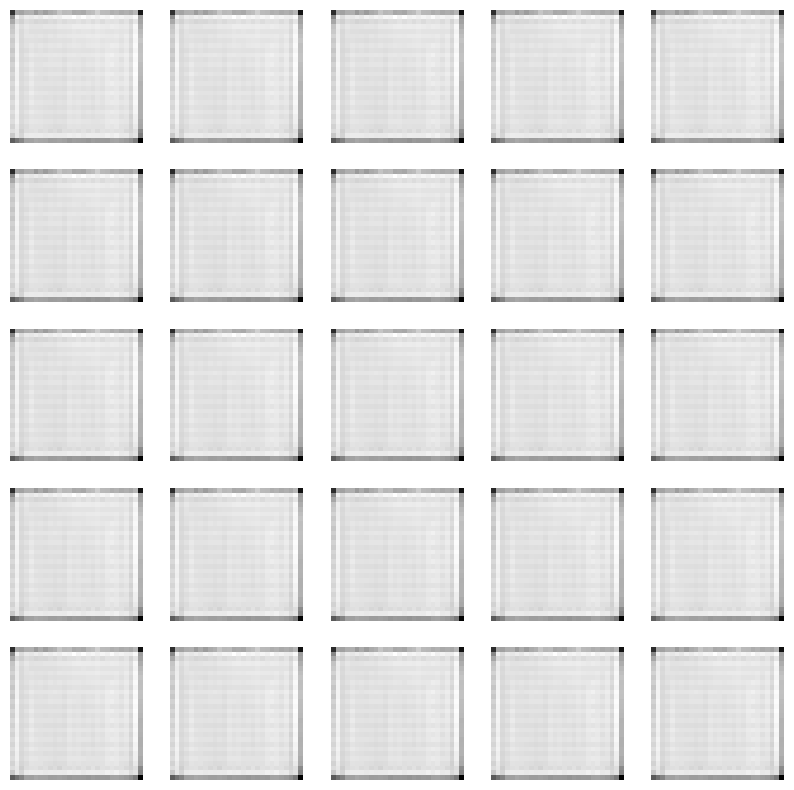

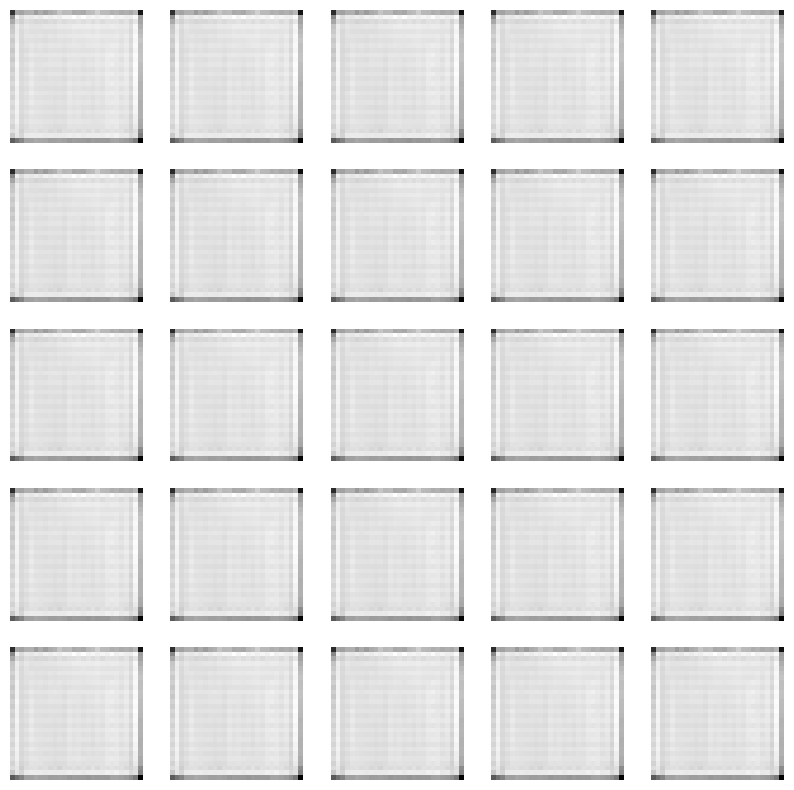

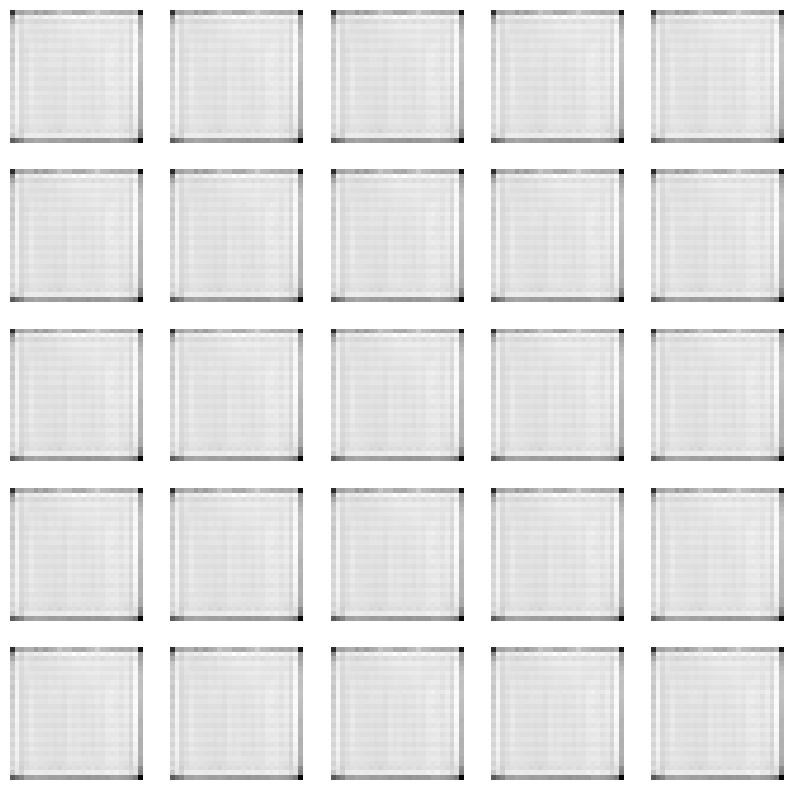

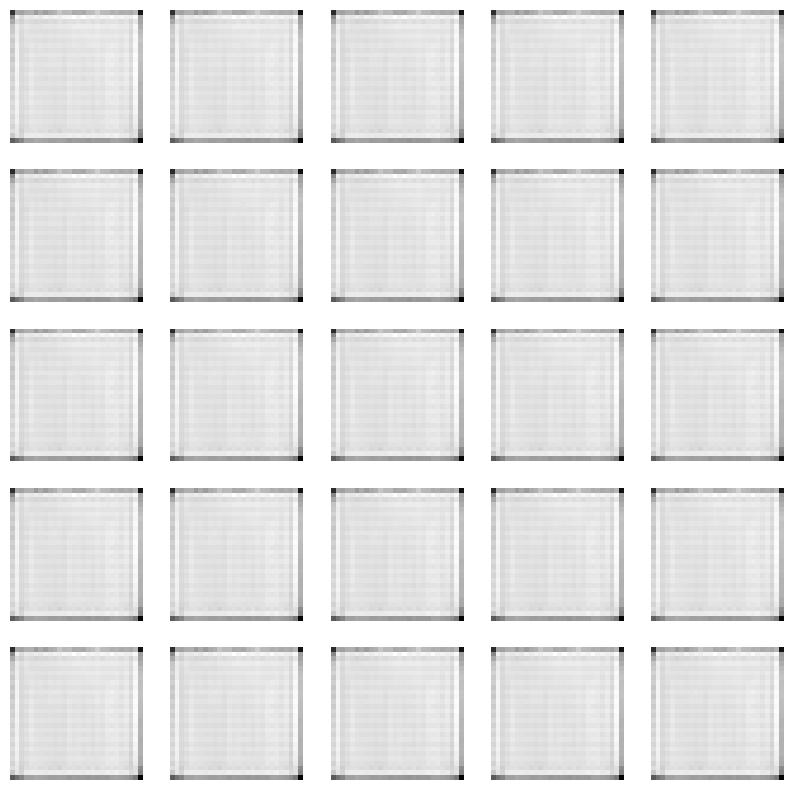

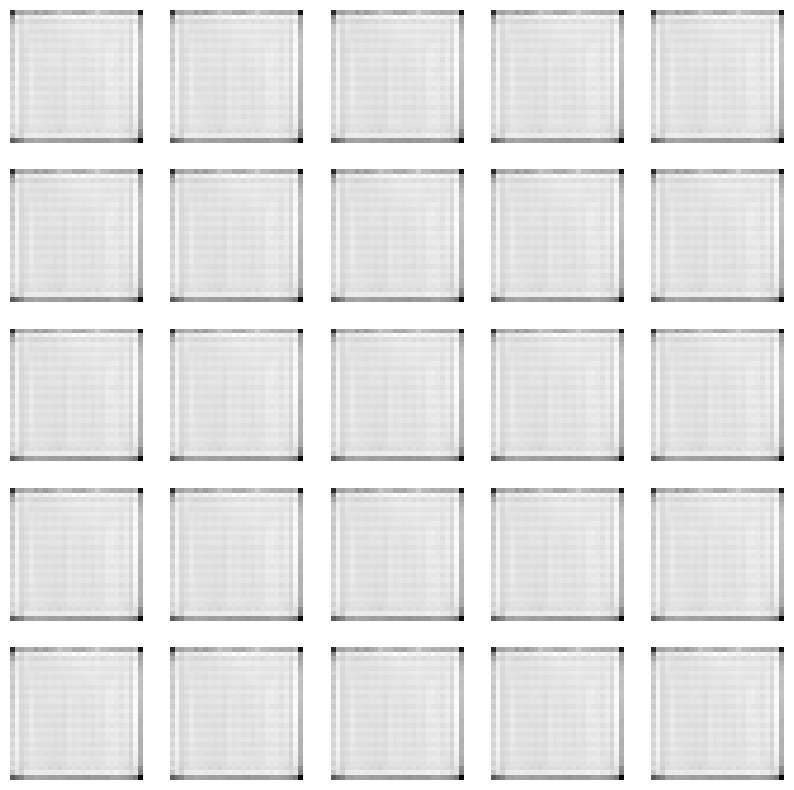

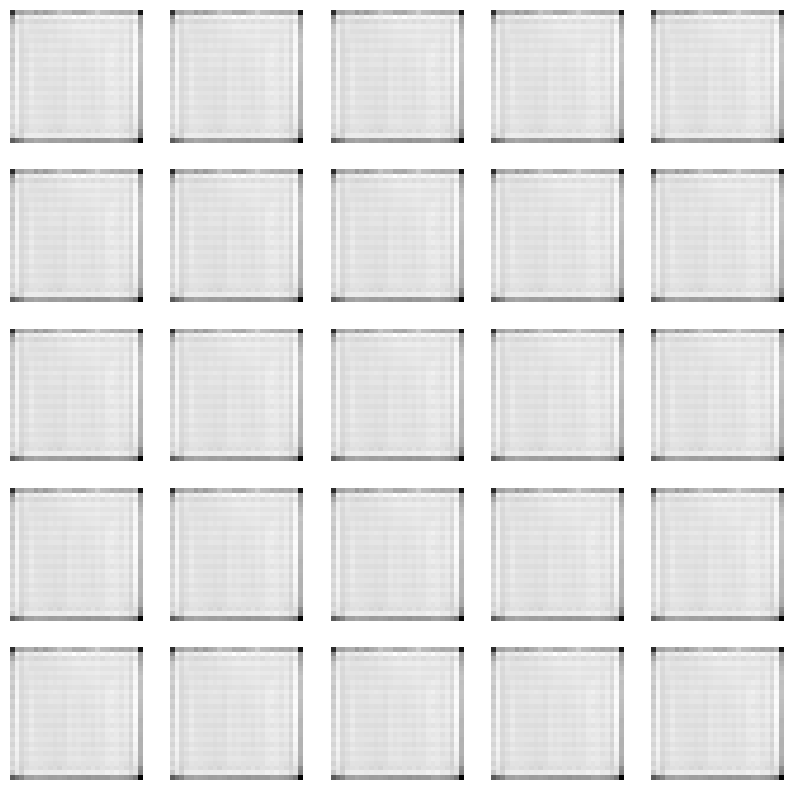

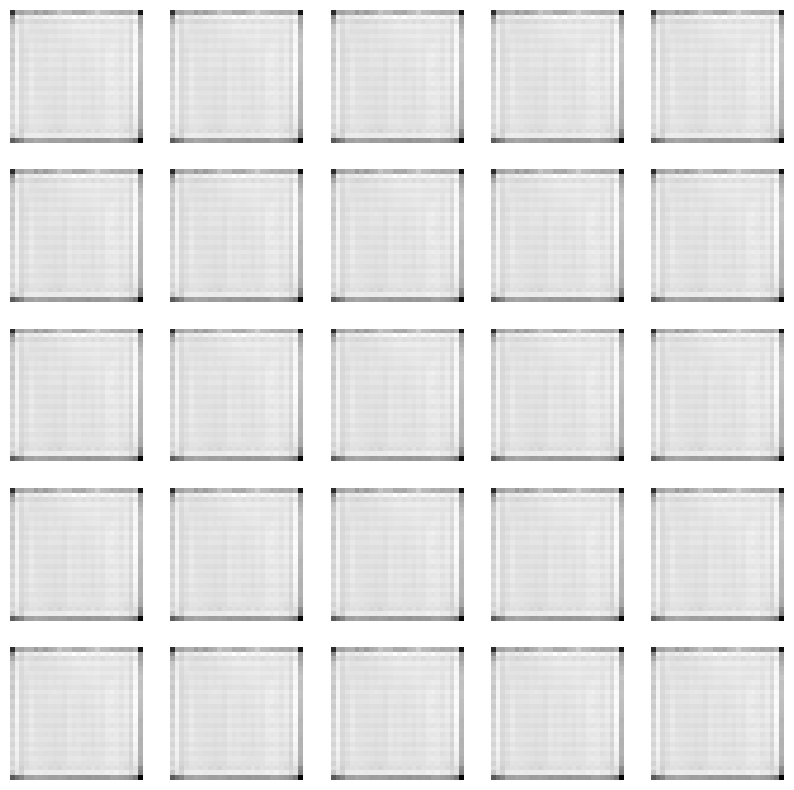

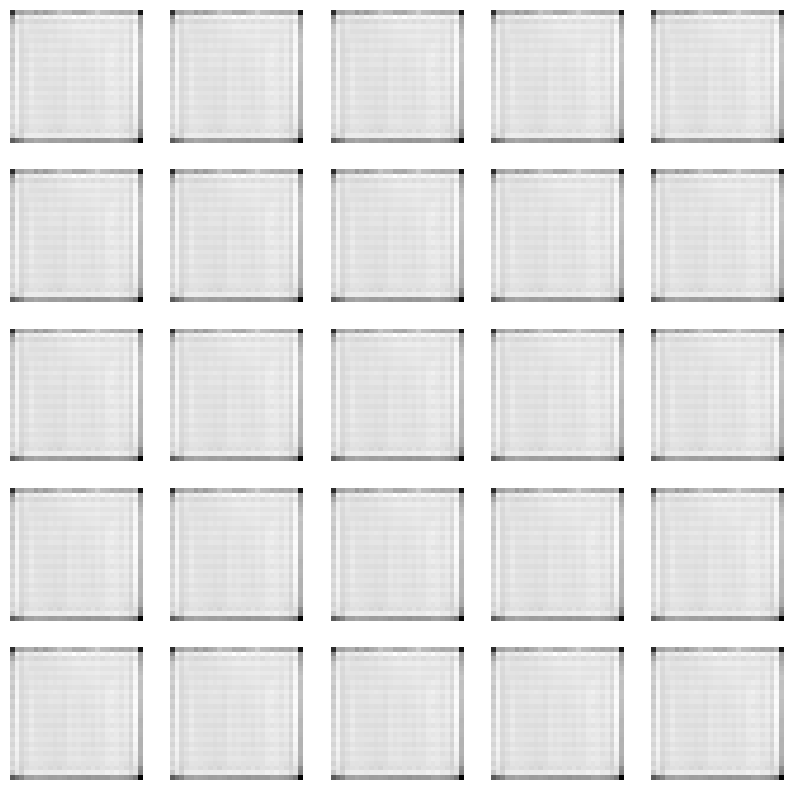

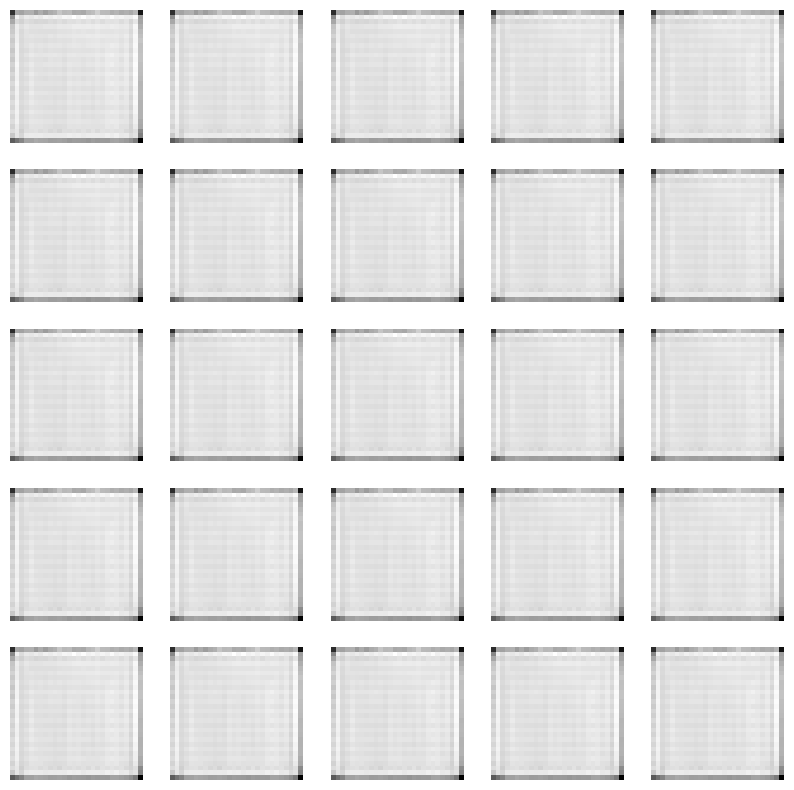

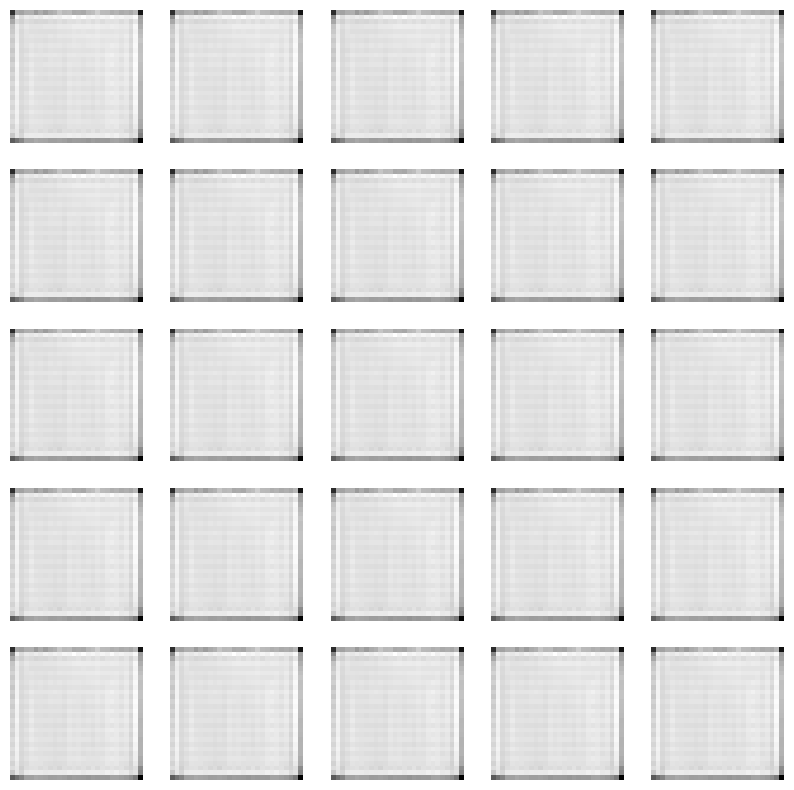

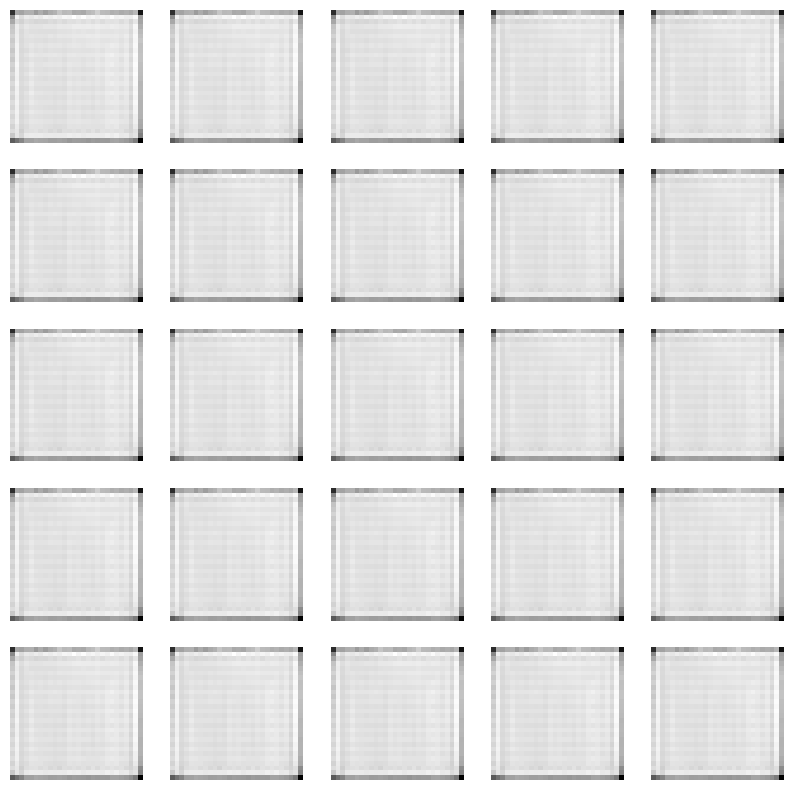

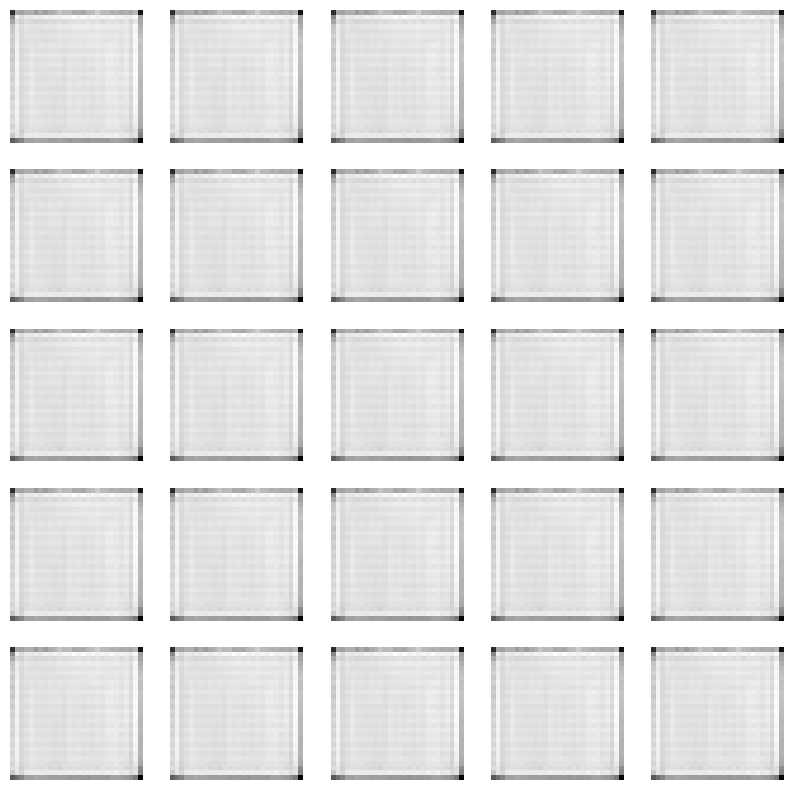

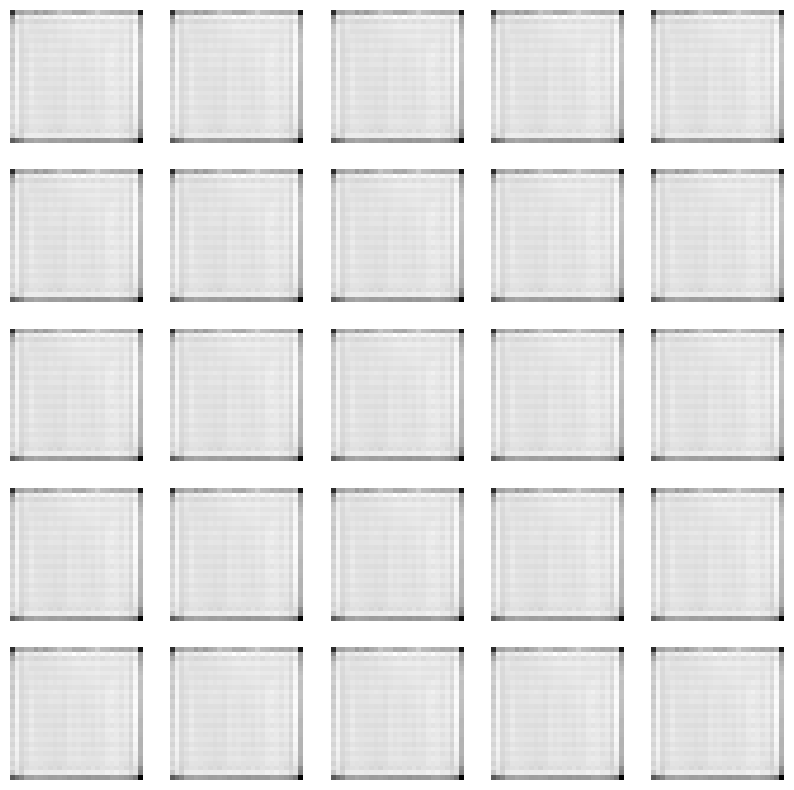

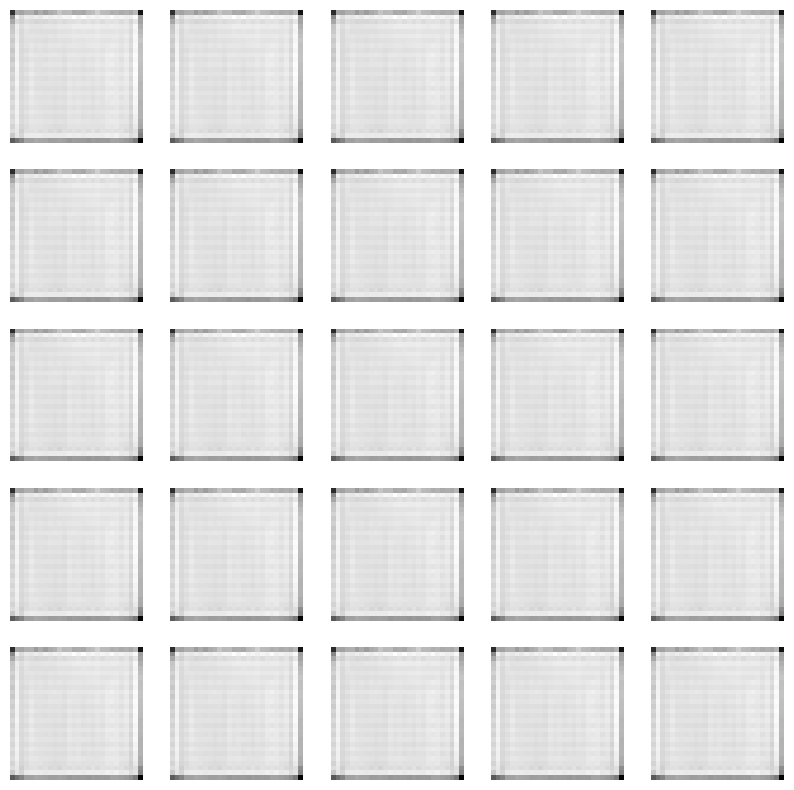

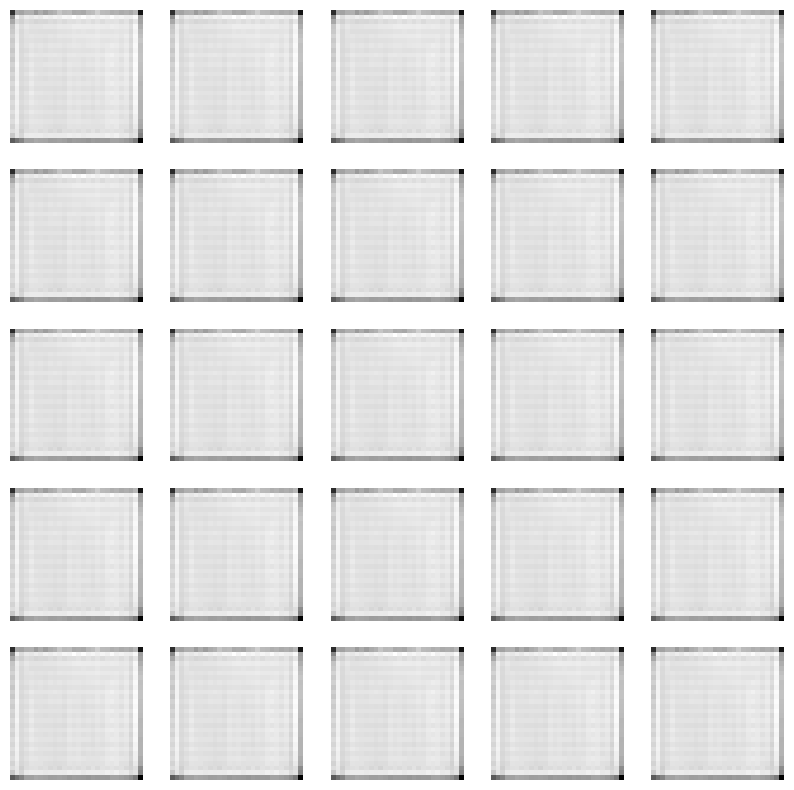

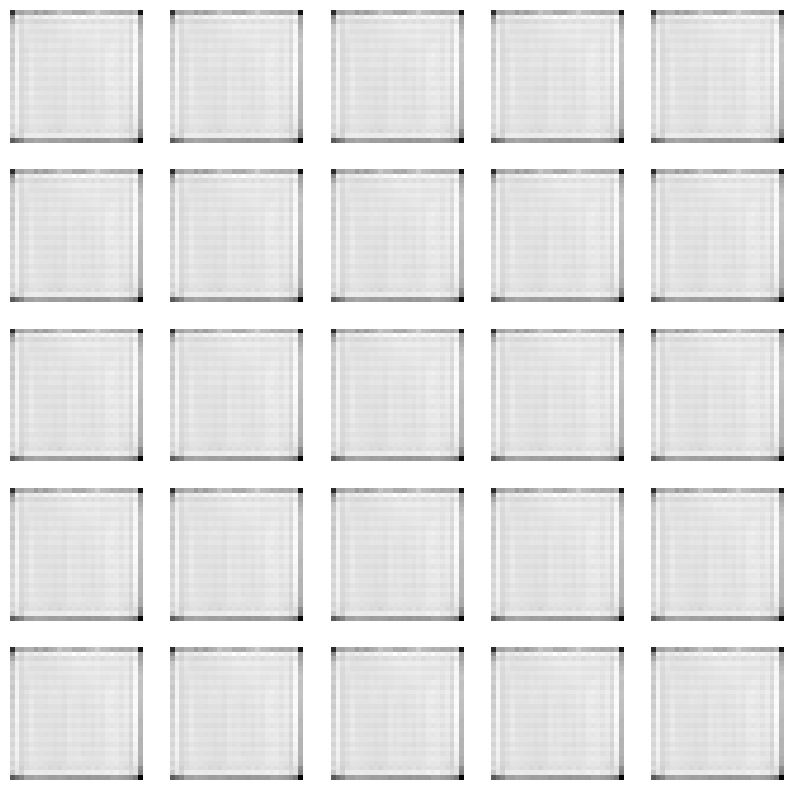

In [48]:
predict(model)


100%|██████████| 50/50 [00:05<00:00,  8.71it/s]


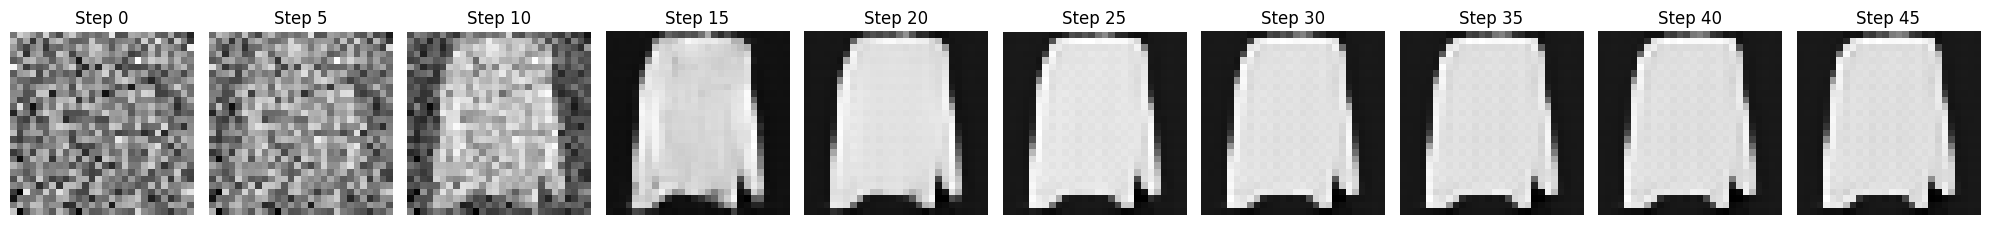

In [49]:
predict_step(model)